## **Merging datasets from kaggle (Jan 1 2020 to Dec 31 2023) + from govt (Jan 1 2024 to May 31 2025)**


In [ ]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load Kaggle CSV
# -------------------------------
kaggle_df = pd.read_csv('kaggle.csv')

# -------------------------------
# 2. Load Govt Excel (skip 16 rows)
# -------------------------------
govt_df = pd.read_excel('govt.xlsx', sheet_name=0, skiprows=16)
govt_df.columns = govt_df.columns.str.strip()  # Clean up column names

# -------------------------------
# 3. Preprocess Kaggle
# -------------------------------
kaggle_df['Datetime'] = pd.to_datetime(kaggle_df['Datetime'], format='mixed', dayfirst=True, errors='coerce')
kaggle_df = kaggle_df.dropna(subset=['Datetime'])
kaggle_df = kaggle_df[kaggle_df['City'].str.lower() == 'delhi']
kaggle_df = kaggle_df.drop(columns=['City'])

# Filter for 2020–2023
kaggle_filtered = kaggle_df[(kaggle_df['Datetime'] >= '2020-01-01') & (kaggle_df['Datetime'] <= '2023-12-31')]

# -------------------------------
# 4. Preprocess Govt
# -------------------------------
govt_df['From Date'] = pd.to_datetime(govt_df['From Date'], format='mixed', dayfirst=True, errors='coerce')
govt_df = govt_df.dropna(subset=['From Date'])

govt_filtered = govt_df[(govt_df['From Date'] >= '2024-01-01') & (govt_df['From Date'] <= '2025-05-31')]
govt_filtered = govt_filtered.rename(columns={'From Date': 'Datetime', 'Ozone': 'O3'})

# Ensure missing columns exist
for col in ['NO', 'NO2', 'Benzene', 'Toluene']:
    if col not in govt_filtered.columns:
        govt_filtered[col] = np.nan

# Fill Benzene and Toluene from Kaggle (same date)
kaggle_lookup = kaggle_df.set_index('Datetime')[['Benzene', 'Toluene']]
govt_filtered.set_index('Datetime', inplace=True)
govt_filtered[['Benzene', 'Toluene']] = govt_filtered[['Benzene', 'Toluene']].fillna(
    kaggle_lookup[['Benzene', 'Toluene']]
)
govt_filtered.reset_index(inplace=True)

# -------------------------------
# 5. AQI Calculation
# -------------------------------
def calculate_sub_index(conc, breakpoints):
    for (low, high, index_low, index_high) in breakpoints:
        if pd.notnull(conc) and low <= conc <= high:
            return round(((index_high - index_low) / (high - low)) * (conc - low) + index_low, 1)
    return None

def calculate_aqi(row):
    pm25_bp = [(0,30,0,50), (31,60,51,100), (61,90,101,200),
               (91,120,201,300), (121,250,301,400), (251,500,401,500)]
    pm10_bp = [(0,50,0,50), (51,100,51,100), (101,250,101,200),
               (251,350,201,300), (351,430,301,400), (431,600,401,500)]
    nox_bp = [(0,40,0,50), (41,80,51,100), (81,180,101,200),
              (181,280,201,300), (281,400,301,400), (401,500,401,500)]
    co_bp = [(0,1,0,50), (1.1,2,51,100), (2.1,10,101,200),
             (10.1,17,201,300), (17.1,34,301,400), (34.1,50,401,500)]
    o3_bp = [(0,50,0,50), (51,100,51,100), (101,168,101,200),
             (169,208,201,300), (209,748,301,500)]

    sub_indices = [
        calculate_sub_index(row['PM2.5'], pm25_bp),
        calculate_sub_index(row['PM10'], pm10_bp),
        calculate_sub_index(row['NOx'], nox_bp),
        calculate_sub_index(row['CO'], co_bp),
        calculate_sub_index(row['O3'], o3_bp)
    ]

    sub_indices = [i for i in sub_indices if i is not None]
    return max(sub_indices) if sub_indices else None

def get_aqi_bucket(aqi):
    if aqi is None: return None
    elif aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

# Apply to both
for df in [kaggle_filtered, govt_filtered]:
    df['AQI'] = df.apply(calculate_aqi, axis=1)
    df['AQI_Bucket'] = df['AQI'].apply(get_aqi_bucket)

# -------------------------------
# 6. Merge and Save
# -------------------------------
columns = ['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket']
final_kaggle = kaggle_filtered[columns]
final_govt = govt_filtered[columns]

combined_df = pd.concat([final_kaggle, final_govt], ignore_index=True)
combined_df = combined_df.sort_values('Datetime')
combined_df.to_csv('merged_delhi_aqi.csv', index=False)

print("✅ Done! Final dataset saved as 'merged_delhi_aqi.csv'")


✅ Done! Final dataset saved as 'merged_delhi_aqi.csv'


<ipython-input-7-60663cbea91b>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AQI'] = df.apply(calculate_aqi, axis=1)
<ipython-input-7-60663cbea91b>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AQI_Bucket'] = df['AQI'].apply(get_aqi_bucket)


## **Exploratory Data Analysis (EDA)**

📌 Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Datetime    2495 non-null   datetime64[ns]
 1   PM2.5       1972 non-null   float64       
 2   PM10        1971 non-null   float64       
 3   NO          2487 non-null   float64       
 4   NO2         1973 non-null   float64       
 5   NOx         1973 non-null   float64       
 6   CO          1973 non-null   float64       
 7   O3          1973 non-null   float64       
 8   Benzene     2193 non-null   float64       
 9   Toluene     2193 non-null   float64       
 10  AQI         1973 non-null   float64       
 11  AQI_Bucket  2495 non-null   object        
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 234.0+ KB
None

🧪 Missing Values:
Datetime        0
PM2.5         523
PM10          524
NO              8
NO2           522
NOx           

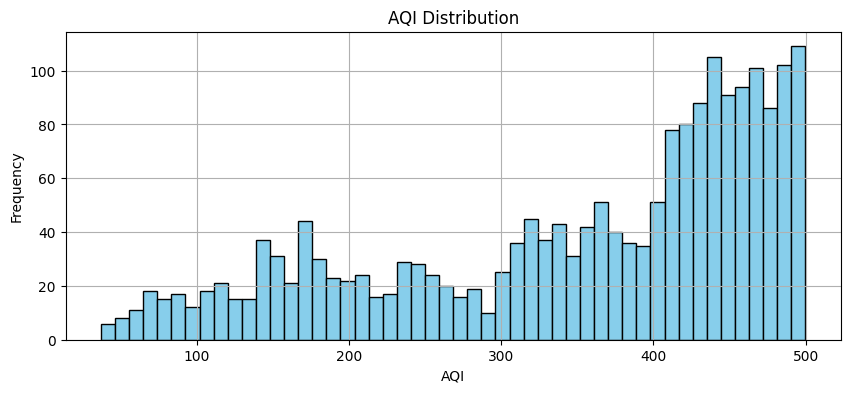


📊 AQI Bucket Counts:
AQI_Bucket
Severe          1501
Very Poor        420
Moderate         270
Poor             217
Satisfactory      78
Good               9
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])

# BASIC INFO
print("📌 Dataset Summary:")
print(df.info())
print("\n🧪 Missing Values:")
print(df.isnull().sum())

# DATE RANGE CHECK
print("\n📅 Date range:", df['Datetime'].min(), "→", df['Datetime'].max())

# SAMPLE DATA
print("\n📄 Sample rows:")
print(df.head())

# DUPLICATE DATES?
dup_dates = df['Datetime'].duplicated().sum()
print(f"\n🌀 Duplicate dates: {dup_dates}")

# AQI Distribution Plot
plt.figure(figsize=(10,4))
df['AQI'].plot.hist(bins=50, color='skyblue', edgecolor='black')
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.grid(True)
plt.show()

# AQI Bucket counts
print("\n📊 AQI Bucket Counts:")
print(df['AQI_Bucket'].value_counts())


## **Data cleaning & preparation**

In [ ]:
import pandas as pd

# -------------------------------
# 1. Load and sort data
# -------------------------------
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Remove duplicates by keeping the most complete row
# -------------------------------
# Add a helper column: count of non-null values
df['non_null_count'] = df.notnull().sum(axis=1)

# Keep only the row with most non-null values per date
df = df.sort_values('non_null_count', ascending=False).drop_duplicates(subset='Datetime', keep='first')

# Drop helper column
df.drop(columns='non_null_count', inplace=True)

# -------------------------------
# 3. Drop rows where key pollutants or AQI are missing
# -------------------------------
required_cols = ['PM2.5', 'PM10', 'NOx', 'CO', 'O3', 'AQI']
df_clean = df.dropna(subset=required_cols)

# -------------------------------
# 4. Save the cleaned dataset
# -------------------------------
df_clean.to_csv('cleaned_delhi_aqi.csv', index=False)
print("✅ Cleaned dataset saved as 'cleaned_delhi_aqi.csv'")
print("🔍 Final shape:", df_clean.shape)


✅ Cleaned dataset saved as 'cleaned_delhi_aqi.csv'
🔍 Final shape: (1971, 12)


In [ ]:
import pandas as pd

# -------------------------------
# 1. Load cleaned dataset
# -------------------------------
df = pd.read_csv('cleaned_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Create missingness indicator columns
# -------------------------------
df['Benzene_missing'] = df['Benzene'].isnull().astype(int)
df['Toluene_missing'] = df['Toluene'].isnull().astype(int)

# -------------------------------
# 3. Impute with forward fill (preserve temporal continuity)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(method='ffill')
df['Toluene'] = df['Toluene'].fillna(method='ffill')

# -------------------------------
# 4. Fill any remaining top-level NaNs with mean (safe fallback)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(df['Benzene'].mean())
df['Toluene'] = df['Toluene'].fillna(df['Toluene'].mean())

# -------------------------------
# 5. Save preprocessed dataset
# -------------------------------
df.to_csv('preprocessed_for_hybrid_dl.csv', index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_for_hybrid_dl.csv'")


✅ Preprocessed dataset saved as 'preprocessed_for_hybrid_dl.csv'


<ipython-input-3-061fabf081c8>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Benzene'] = df['Benzene'].fillna(method='ffill')
<ipython-input-3-061fabf081c8>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Toluene'] = df['Toluene'].fillna(method='ffill')


In [ ]:
# Safest and cleanest option:
df_clean['NO'] = df_clean['NO'].fillna(method='ffill')


<ipython-input-6-e4df10504e52>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean['NO'] = df_clean['NO'].fillna(method='ffill')


In [ ]:
df_clean.to_csv('final_preprocessed_for_dl.csv', index=False)
print("✅ Final version saved with NO imputed.")


✅ Final version saved with NO imputed.


In [ ]:
# Load the final preprocessed dataset (if not already loaded)
df_clean = pd.read_csv('final_preprocessed_for_dl.csv', parse_dates=['Datetime'])

# Print the date range
print("📅 Cleaned date range:", df_clean['Datetime'].min(), "→", df_clean['Datetime'].max())

# Print count of missing values per column
print("🧪 Remaining missing values:\n", df_clean.isnull().sum())


📅 Cleaned date range: 2020-01-01 00:00:00 → 2025-05-31 00:00:00
🧪 Remaining missing values:
 Datetime           0
PM2.5              0
PM10               0
NO                 0
NO2                0
NOx                0
CO                 0
O3                 0
Benzene            0
Toluene            0
AQI                0
AQI_Bucket         0
Benzene_missing    0
Toluene_missing    0
dtype: int64


**Save dataset as "Delhi_monthly.csv"**

## **Data pre-processing**

**MinMaxScaler**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your dataset
delhi_data = pd.read_csv('Delhi_monthly.csv', parse_dates=['Datetime'])

# Define columns to scale
scale_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']

# Initialize and fit scaler
scaler = MinMaxScaler()
delhi_data[scale_cols] = scaler.fit_transform(delhi_data[scale_cols])

# Save scaler for inverse_transform later (optional)
joblib.dump(scaler, 'scaler.pkl')

# Save scaled dataset to CSV
delhi_data.to_csv('scaled_for_sequences.csv', index=False)

print("✅ Scaled data saved to 'scaled_for_sequences.csv'")
print("✅ Scaler saved to 'scaler.pkl'")


✅ Scaled data saved to 'scaled_for_sequences.csv'
✅ Scaler saved to 'scaler.pkl'


## **Run From here**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the scaled dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'


In [ ]:
print("✅ Columns in scaled file:")
print(df.columns.tolist())

print("📦 Sample features shape:", df[features].shape)
print("🎯 Target preview:", df[target].head())


✅ Columns in scaled file:
['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket', 'Benzene_missing', 'Toluene_missing']
📦 Sample features shape: (1971, 11)
🎯 Target preview: 0    483.2
1    340.1
2    292.8
3    444.6
4    420.2
Name: AQI, dtype: float64


In [ ]:
import numpy as np

def create_sequences(data, feature_cols, target_col, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[feature_cols].iloc[i:i+sequence_length].values)
        y.append(data[target_col].iloc[i+sequence_length])
    return np.array(X), np.array(y)


In [ ]:
# Set your sequence length
sequence_length = 12

# Load dataset
import pandas as pd
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Define features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'

# Generate sequences
X, y = create_sequences(df, features, target, sequence_length=sequence_length)

# Train/Val/Test Split (e.g., 70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ Shapes:
Train: (1371, 12, 11) (1371,)
Val:   (391, 12, 11) (391,)
Test:  (197, 12, 11) (197,)


In [ ]:
df = pd.read_csv('scaled_for_sequences.csv')

print("Number of records:", len(df))

Number of records: 1971


# Feature selection

# 1. correlational analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Select features and target
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Combine features and target for correlation analysis
correlation_data = features.copy()
correlation_data['AQI'] = target

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

In [ ]:
# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
            PM2.5      PM10        NO       NO2       NOx        CO        O3  \
PM2.5    1.000000  0.179462  0.282154  0.249976  0.266269  0.271562  0.237468   
PM10     0.179462  1.000000  0.176018  0.117898  0.150548  0.115583  0.135330   
NO       0.282154  0.176018  1.000000  0.330753  0.356251  0.334330  0.312711   
NO2      0.249976  0.117898  0.330753  1.000000  0.313243  0.322730  0.297050   
NOx      0.266269  0.150548  0.356251  0.313243  1.000000  0.341205  0.272189   
CO       0.271562  0.115583  0.334330  0.322730  0.341205  1.000000  0.315891   
O3       0.237468  0.135330  0.312711  0.297050  0.272189  0.315891  1.000000   
Benzene  0.045698  0.030237  0.055996  0.038340  0.000621  0.063341  0.048945   
Toluene  0.065847  0.043796  0.106072  0.074275  0.056901  0.072299  0.082214   
AQI      0.781414  0.507493  0.416981  0.377513  0.415229  0.394496  0.369109   

          Benzene   Toluene       AQI  
PM2.5    0.045698  0.065847  0.781414  
PM10    

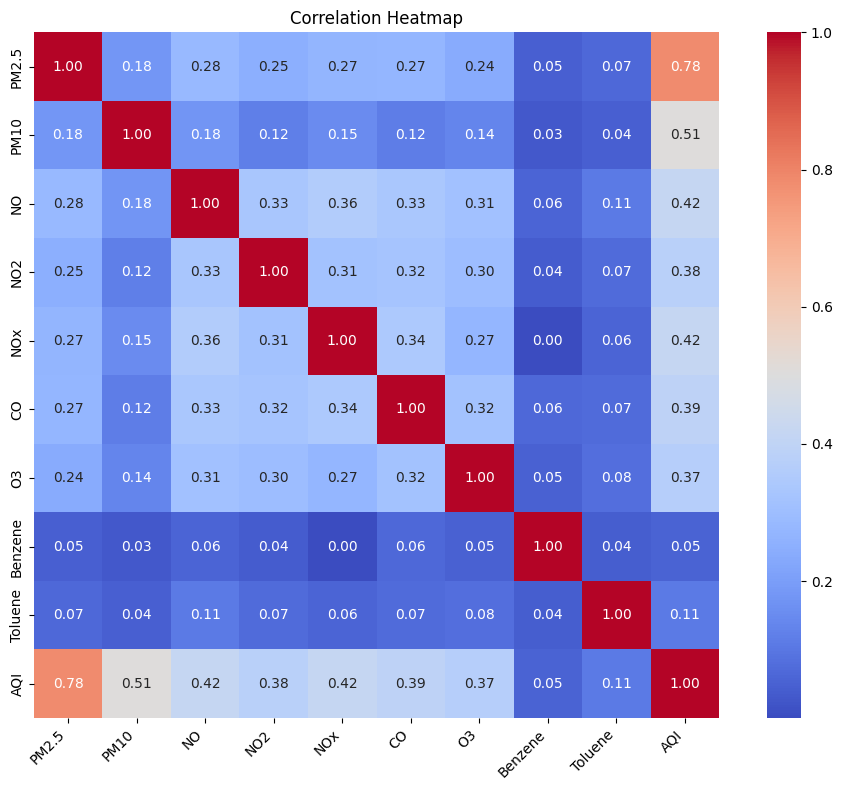

In [ ]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




---
correlational analysis clearly shows that benzene and toluene show the least correlation with AQI and can be said to have less impact on its change.



---

# 2. Lasso Regularization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Check for missing values and handle them if needed
if data.isnull().sum().any():
    print("Missing values detected. Handling them...")
    data.fillna(data.mean(), inplace=True)  # Fill missing values with column mean

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Lasso Regression
lasso_model = Lasso(alpha=0.8, random_state=42) # <--- modify the alpha value to control strength of lasso
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)

# Calculate RMSE
try:
    # If scikit-learn supports squared=False
    rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
except TypeError:
    # Manual calculation for older scikit-learn versions
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    rmse_lasso = mse_lasso ** 0.5

print(f"RMSE (Lasso Regression): {rmse_lasso}")


RMSE (Lasso Regression): 50.90541161411084





---
alpha = Regularization parameter controlling the strength of Lasso. Smaller values allow more features, while larger values shrink coefficients aggressively.



---

* RMSE for alpha 0.01 = 50.267786580740456
* RMSE for alpha 0.05 = 50.28092428093257
* RMSE for alpha 0.1 = 50.300152280835576 ( removes benzene )
* RMSE for alpha 0.8 = 50.90541161411084 ( removes benzene and toulene )


---





> baseline RMSE and cross validation --->



In [ ]:
from sklearn.metrics import mean_squared_error

# Baseline model
y_baseline = y_test.mean()
rmse_baseline = mean_squared_error(y_test, [y_baseline] * len(y_test))**0.5
print(f"Baseline RMSE: {rmse_baseline}")


Baseline RMSE: 126.11004233001482


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"Average RMSE from Cross-Validation: {np.mean(-cv_scores)}")


Average RMSE from Cross-Validation: 55.49566452144334




> features selection are as follows-->



In [ ]:
# Extract feature importance from Lasso
feature_coefficients = pd.Series(lasso_model.coef_, index=features.columns)

# Select features with non-zero coefficients
selected_features = feature_coefficients[feature_coefficients != 0].index.tolist()
print("Selected Features:", selected_features)


Selected Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")


Performance Metrics:
RMSE: 50.2500
MAE: 42.2662
MAPE: 17.42%
R-Squared: 0.8412





---
as RMSE decreases benzene is not an important factor.



---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Toluene and Benzene from the dataset
features_selected = features.drop(columns=['Benzene', 'Toluene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")



Performance Metrics:
RMSE: 50.4364
MAE: 42.3606
MAPE: 17.48%
R-Squared: 0.8400






---
as rmse increases on removal of toluene , it does influence AQI to an extent.





---

# 3. Random Forest Regression:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_selected)

# Compute performance metrics
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5  # RMSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)         # Mean Absolute Error
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_rf = r2_score(y_test, y_pred_rf)                     # R-Squared

# Print metrics
print("Performance Metrics for Random Forest:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"MAPE: {mape_rf:.2f}%")
print(f"R-Squared: {r2_rf:.4f}")


Performance Metrics for Random Forest:
RMSE: 6.9450
MAE: 2.5822
MAPE: 1.31%
R-Squared: 0.9970




---
* Low Errors: Both RMSE (6.9450) and MAE (2.5822) indicate minimal prediction errors, especially given the typical AQI range.

* High Accuracy: A MAPE of 1.31% suggests the model is highly accurate and consistent.

* Excellent Fit: An R-Squared value of 0.9970 confirms that the model explains almost all variability in AQI values based on the input features.
---

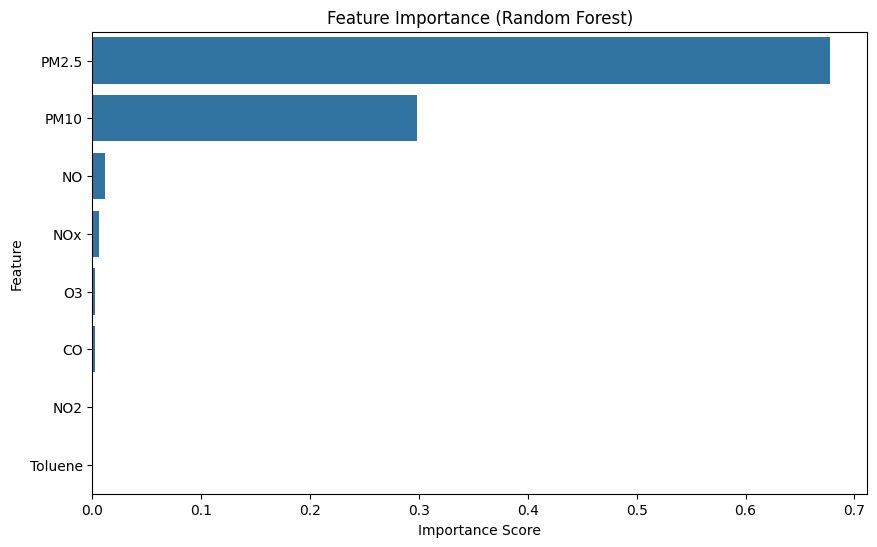

   Feature  Importance
0    PM2.5    0.677940
1     PM10    0.298713
2       NO    0.011603
4      NOx    0.006345
6       O3    0.002470
5       CO    0.002248
3      NO2    0.000370
7  Toluene    0.000312


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
importance = rf_model.feature_importances_
feature_names = features_selected.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)


---
choosing threshold on the basis of pre existing knowledge regarding correlation of AQI and pollutants


---

In [ ]:
# Set a threshold for importance
threshold = 0.001
relevant_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

# Print relevant features
print("\nRelevant Features Selected:")
print(relevant_features)

# Update features with only relevant ones
features_relevant = features_selected[relevant_features]

# Train-test split with relevant features
X_train_relevant, X_test_relevant, y_train, y_test = train_test_split(
    features_relevant, target, test_size=0.2, random_state=42
)

# Retrain Random Forest with relevant features
rf_model_relevant = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_relevant.fit(X_train_relevant, y_train)

# Predict and evaluate
y_pred_relevant = rf_model_relevant.predict(X_test_relevant)

# Compute performance metrics
rmse_relevant = mean_squared_error(y_test, y_pred_relevant) ** 0.5  # RMSE
mae_relevant = mean_absolute_error(y_test, y_pred_relevant)         # MAE
mape_relevant = (abs((y_test - y_pred_relevant) / y_test).mean()) * 100  # MAPE
r2_relevant = r2_score(y_test, y_pred_relevant)                     # R²

# Print performance metrics
print(f"\nPerformance Metrics with Relevant Features:")
print(f"RMSE: {rmse_relevant:.4f}")
print(f"MAE: {mae_relevant:.4f}")
print(f"MAPE: {mape_relevant:.2f}%")
print(f"R-Squared: {r2_relevant:.4f}")


Relevant Features Selected:
['PM2.5', 'PM10', 'NO', 'NOx', 'O3', 'CO']

Performance Metrics with Relevant Features:
RMSE: 6.5904
MAE: 2.4028
MAPE: 1.21%
R-Squared: 0.9973




---
hence toluene and NO2 can be removed from consideration.





---

# 4. SVM (Support Vector Machine) Regressor:

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd


In [ ]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


In [ ]:
# Train SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train, y_train)


SVR()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best model
svm_model_best = grid_search.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


In [ ]:
# Predict on test data
y_pred = svm_model_best.predict(X_test)

# Compute performance metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
mae = mean_absolute_error(y_test, y_pred)        # MAE
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # MAPE
r2 = r2_score(y_test, y_pred)                    # R²

# Print performance metrics
print(f"\nPerformance Metrics (SVM Regressor with Best Parameters):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-Squared: {r2:.4f}")



Performance Metrics (SVM Regressor with Best Parameters):
RMSE: 18.1653
MAE: 12.0888
MAPE: 5.10%
R-Squared: 0.9793


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize SVM with RBF kernel
svr_rbf = SVR(kernel='rbf', C=100, epsilon=1) # <--- taking values from the best parameter assessment

# Recursive Feature Elimination (Simulated)
feature_names = list(features.columns)
selected_features = feature_names[:]  # Start with all features
min_rmse = float('inf')
best_features = selected_features[:]

print("Starting Feature Selection...")
for i in range(len(feature_names), 0, -1):
    # Train the model on the current feature subset
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    svr_rbf.fit(X_train_subset, y_train)

    # Predict and calculate RMSE
    y_pred = svr_rbf.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)  # Compute MSE
    rmse = mse ** 0.5  # Calculate RMSE manually

    print(f"Features: {selected_features}, RMSE: {rmse}")

    # Update the best feature set
    if rmse < min_rmse:
        min_rmse = rmse
        best_features = selected_features[:]

    # Remove the least important feature (one at a time)
    if len(selected_features) > 1:
        feature_to_remove = selected_features.pop()

# Display the best feature set
print(f"Best Features: {best_features}")
print(f"Minimum RMSE: {min_rmse}")

# Train final SVM with the best feature set
final_X_train = X_train[best_features]
final_X_test = X_test[best_features]

svr_rbf.fit(final_X_train, y_train)
final_y_pred = svr_rbf.predict(final_X_test)
final_rmse = mean_squared_error(y_test, final_y_pred) ** 0.5  # Compute RMSE manually

print(f"Final RMSE with Best Features: {final_rmse}")


Starting Feature Selection...
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene'], RMSE: 21.89897504977403
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene'], RMSE: 20.594187760517926
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3'], RMSE: 18.92788258887062
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO'], RMSE: 17.9386173983706
Features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx'], RMSE: 16.124435342955053
Features: ['PM2.5', 'PM10', 'NO', 'NO2'], RMSE: 16.37688404410545
Features: ['PM2.5', 'PM10', 'NO'], RMSE: 14.857799892540864
Features: ['PM2.5', 'PM10'], RMSE: 18.697989735879823
Features: ['PM2.5'], RMSE: 68.70761269651405
Best Features: ['PM2.5', 'PM10', 'NO']
Minimum RMSE: 14.857799892540864
Final RMSE with Best Features: 14.857799892540864


## **CNN ABLATION STUDY**

In [ ]:
# Import necessary libraries
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Load the scaled dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

In [ ]:
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

X = df[features].values
y = df[target].values

In [ ]:
# Train/Val/Test Split (e.g., 70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

✅ Shapes:
Train: (1379, 6) (1379,)
Val:   (394, 6) (394,)
Test:  (198, 6) (198,)


In [ ]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## **Number of layers = 2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model1 = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(1)  # Output layer for regression
])

# Optimizer (learning rate 0.1 is quite high — might want to try 0.001 too)
optimizer1 = Adam(learning_rate=0.1)

# Compile the model
model1.compile(optimizer=optimizer1, loss='mse', metrics=['mae'])

# Train the model
history1 = model1.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 56678.1250 - mae: 192.2322 - val_loss: 10215.0439 - val_mae: 89.6767
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6637.4932 - mae: 64.6862 - val_loss: 12021.1484 - val_mae: 89.6577
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2741.4299 - mae: 40.2193 - val_loss: 8248.4355 - val_mae: 75.0610
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2568.9382 - mae: 39.8550 - val_loss: 13762.5713 - val_mae: 99.4080
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2163.2900 - mae: 35.0387 - val_loss: 11130.6816 - val_mae: 86.3461
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1707.1392 - mae: 30.4499 - val_loss: 10103.9453 - val_mae: 81.9690
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1498.1293 - mae: 29.4503 - val_loss: 9034.5195 - val_mae: 78.0548
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1426.7864 - mae: 29.0700 - val_loss: 11119.6260 - val_mae: 87.13

## **Number of layers = 4**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model2 = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(1)  # Output for regression
])

optimizer2 = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer2, loss='mse', metrics=['mae'])

history2 = model2.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 165017.0781 - mae: 395.9968 - val_loss: 36907.6562 - val_mae: 157.1213
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37099.8477 - mae: 160.4792 - val_loss: 8707.2168 - val_mae: 82.5977
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10073.6367 - mae: 78.2010 - val_loss: 9182.5117 - val_mae: 85.0272
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9062.5205 - mae: 76.6164 - val_loss: 11663.5771 - val_mae: 93.5200
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8087.5781 - mae: 70.6580 - val_loss: 12336.3438 - val_mae: 95.8377
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7786.9355 - mae: 70.8217 - val_loss: 16753.0117 - val_mae: 107.3441
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6655.7393 - mae: 64.1532 - val_loss: 18388.0625 - val_mae: 111.8602
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5550.5229 - mae: 56.5252 - val_loss: 19293.0781 - val_mae

## **Number of layers = 6**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model3 = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),
    Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),
    Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),
    Conv1D(filters=256, kernel_size=2, activation='relu', padding='same'),
    Flatten(),
    Dense(1)  # Output for regression
])

optimizer3 = Adam(learning_rate=0.001)

model3.compile(optimizer=optimizer3, loss='mse', metrics=['mae'])

history3 = model3.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 139448.8438 - mae: 351.3828 - val_loss: 9635.0098 - val_mae: 79.9639
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 12161.1807 - mae: 89.3941 - val_loss: 10659.5029 - val_mae: 91.2124
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10322.5703 - mae: 82.0191 - val_loss: 14804.7588 - val_mae: 105.2074
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8738.3584 - mae: 75.3137 - val_loss: 19086.8828 - val_mae: 116.2878
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8248.4033 - mae: 70.9996 - val_loss: 29384.8145 - val_mae: 142.3048
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7855.7749 - mae: 69.3532 - val_loss: 31724.0312 - val_mae: 148.6460
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7755.1704 - mae: 69.2429 - val_loss: 26083.9434 - val_mae: 135.7853
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8751.4717 - mae: 75.5172 - val_loss: 26334.2734 - val_mae

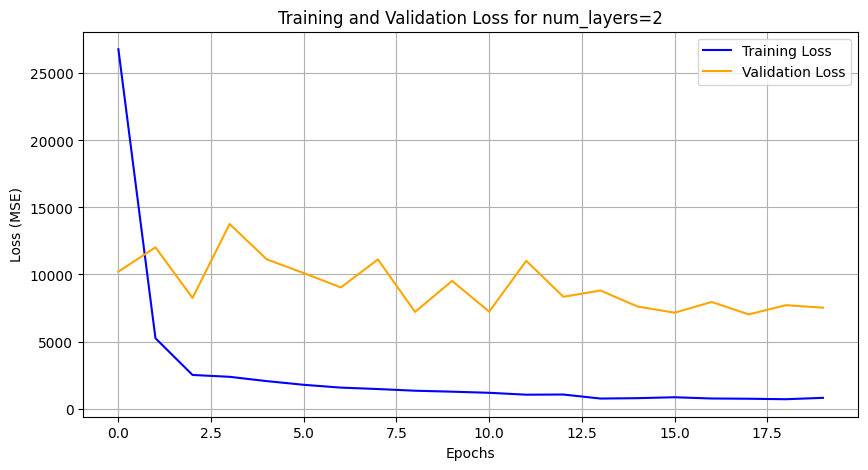

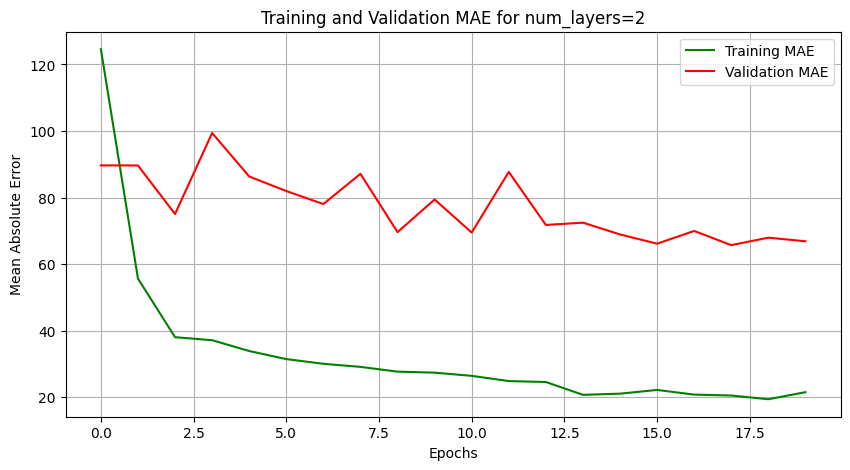

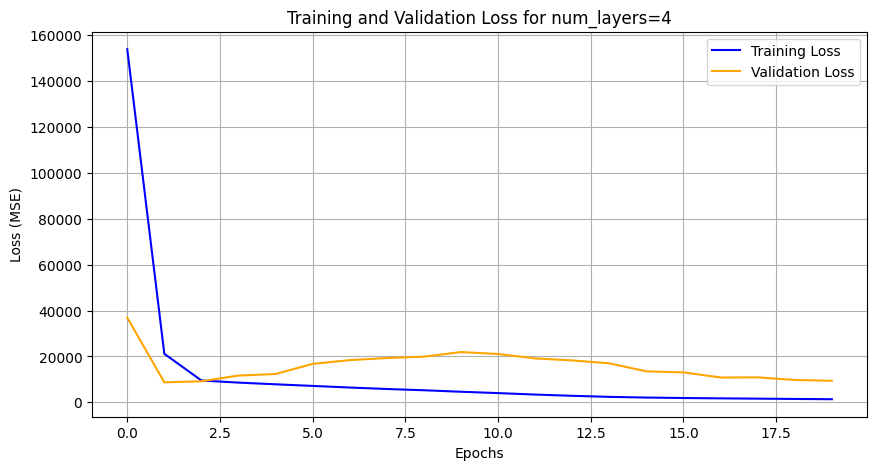

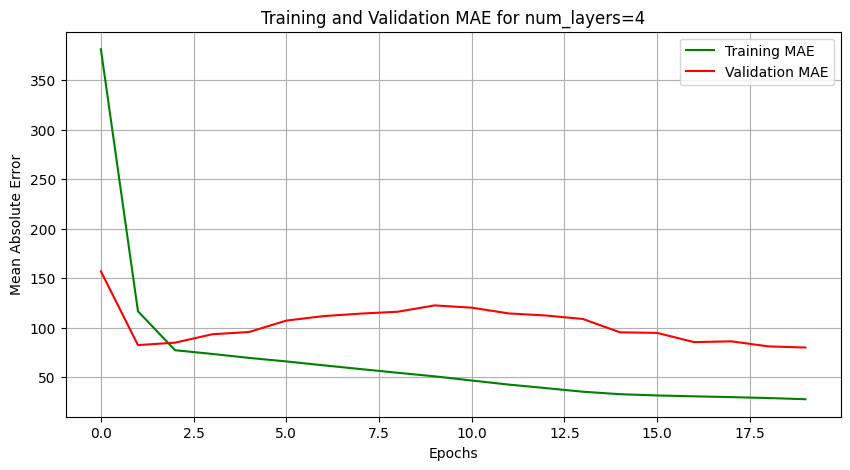

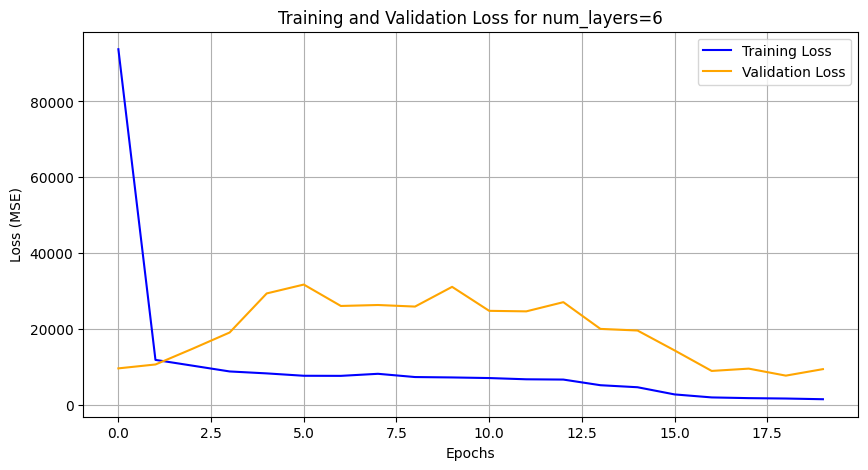

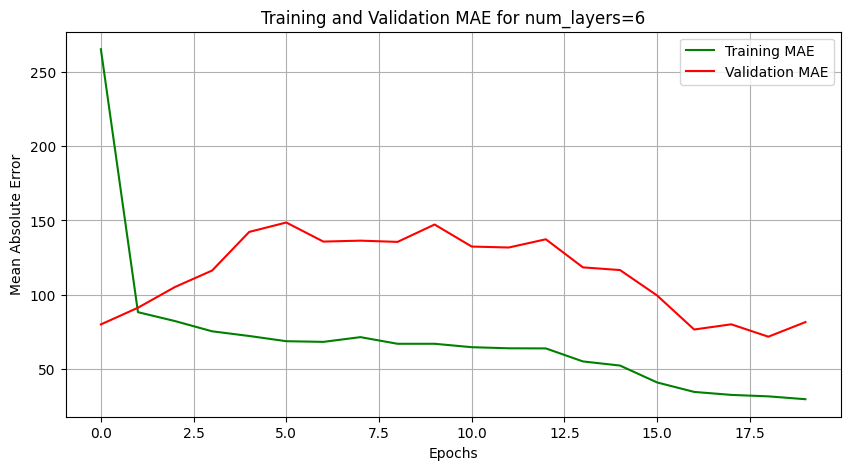

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have history1, history2, history3
histories = [history1, history2, history3]
num_layers = [2, 4, 6]

for history, n in zip(histories, num_layers):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for num_layers={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for num_layers={n}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models
evaluate_model(model1, X_test_cnn, y_test, name="Model 1")
evaluate_model(model2, X_test_cnn, y_test, name="Model 2")
evaluate_model(model3, X_test_cnn, y_test, name="Model 3")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 Model 1 Metrics:
 - R²:   0.3156
 - RMSE: 89.2564
 - MAE:  67.2917
 - MAPE: 49.60%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 Model 2 Metrics:
 - R²:   0.1469
 - RMSE: 99.6517
 - MAE:  79.3383
 - MAPE: 56.40%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 Model 3 Metrics:
 - R²:   0.1561
 - RMSE: 99.1155
 - MAE:  80.4272
 - MAPE: 56.10%



## **CHOSE MODEL WITH NO. OF LAYERS = 2**

## **64->128 filters per layer**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the updated model
model_filters_1 = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_filters_1 = Adam(learning_rate=0.1)

# Compile the model
model_filters_1.compile(optimizer=optimizer_filters_1, loss='mse', metrics=['mae'])

# Train the model
history_filters_1 = model_filters_1.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 68392.3047 - mae: 219.6346 - val_loss: 25168.3242 - val_mae: 135.9854
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7229.4346 - mae: 66.1423 - val_loss: 17657.2227 - val_mae: 108.8811
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2988.4846 - mae: 40.7033 - val_loss: 12446.3984 - val_mae: 92.9714
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2248.6753 - mae: 36.8171 - val_loss: 12667.2295 - val_mae: 94.0371
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2446.1086 - mae: 37.6776 - val_loss: 9170.7627 - val_mae: 77.6371
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1960.0164 - mae: 33.9569 - val_loss: 8622.1787 - val_mae: 75.7728
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1885.2214 - mae: 33.1085 - val_loss: 7520.1548 - val_mae: 72.5625
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1992.5200 - mae: 34.9651 - val_loss: 9119.9619 - val_mae: 78.1790

## **128 -> 256 filters per layer**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the updated model
model_filters_2 = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=256, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_filters_2 = Adam(learning_rate=0.1)

# Compile the model
model_filters_2.compile(optimizer=optimizer_filters_2, loss='mse', metrics=['mae'])

# Train the model
history_filters_2 = model_filters_2.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 132348.6406 - mae: 320.8393 - val_loss: 20107.0312 - val_mae: 118.2344
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8893.2803 - mae: 75.7401 - val_loss: 18579.8242 - val_mae: 112.7145
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5943.2192 - mae: 60.5964 - val_loss: 20009.8457 - val_mae: 115.8909
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4121.8242 - mae: 46.9566 - val_loss: 12748.2188 - val_mae: 90.5473
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2651.4048 - mae: 38.1294 - val_loss: 11598.1182 - val_mae: 88.5804
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2270.5957 - mae: 36.9917 - val_loss: 15083.1201 - val_mae: 106.1889
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2551.3938 - mae: 39.0065 - val_loss: 11192.8857 - val_mae: 86.2575
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2485.9775 - mae: 38.5903 - val_loss: 12520.2529 - val_mae: 92.1999
Epo

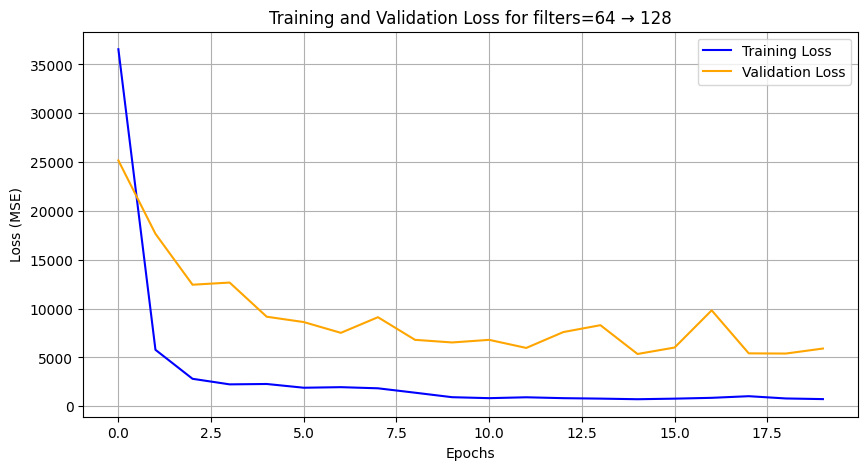

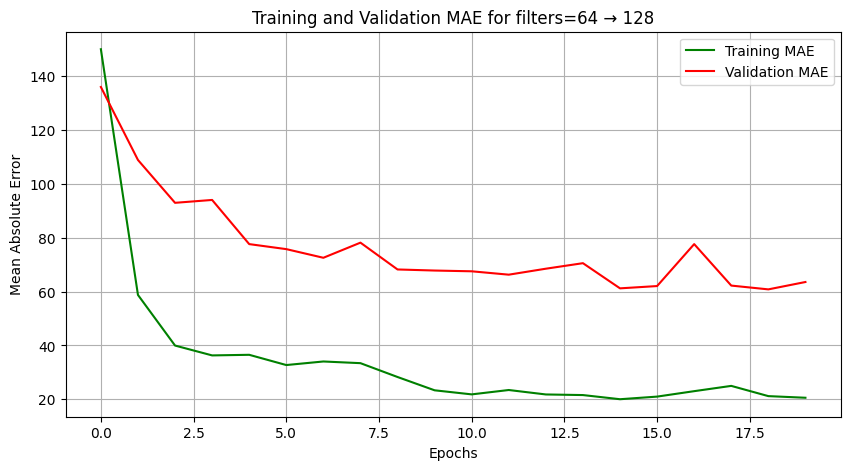

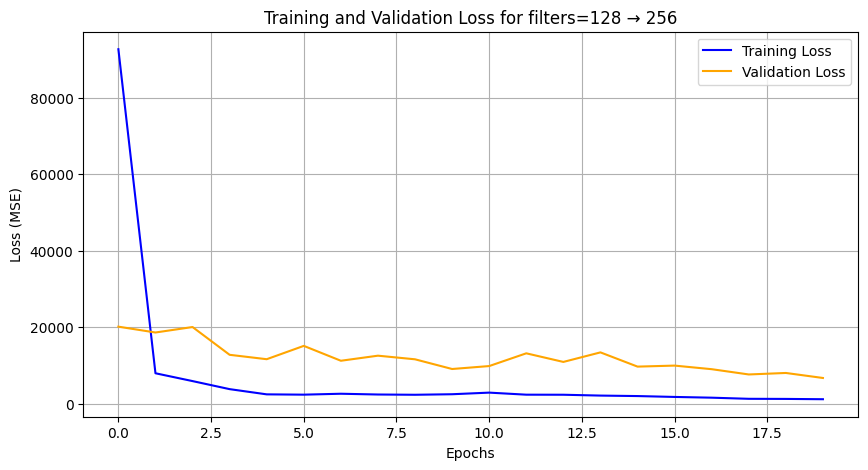

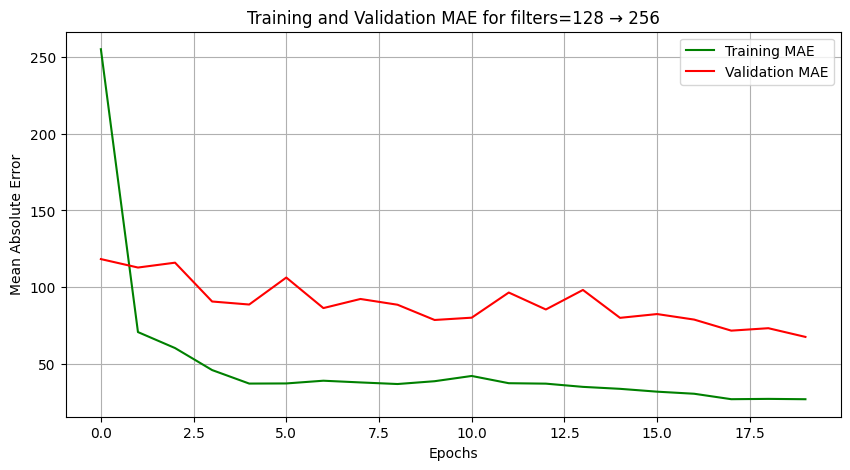

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_filters_1, history_filters_2]
filter_configs = ['64 → 128', '128 → 256']

for history, config in zip(histories, filter_configs):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_filters_1, X_test_cnn, y_test, name="64 -> 128")
evaluate_model(model_filters_2, X_test_cnn, y_test, name="128 -> 256")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
📊 64 -> 128 Metrics:
 - R²:   0.4753
 - RMSE: 78.1521
 - MAE:  62.9294
 - MAPE: 43.57%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 128 -> 256 Metrics:
 - R²:   0.4166
 - RMSE: 82.4062
 - MAE:  65.3814
 - MAPE: 46.14%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128**

## **LeakyReLU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the updated model with LeakyReLU activations
model_leakyrelu = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    LeakyReLU(alpha=0.1),  # Alpha is the negative slope

    Conv1D(filters=128, kernel_size=2),
    LeakyReLU(alpha=0.1),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_leakyrelu = Adam(learning_rate=0.1)

# Compile the model
model_leakyrelu.compile(optimizer=optimizer_leakyrelu, loss='mse', metrics=['mae'])

# Train the model
history_leakyrelu = model_leakyrelu.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 50117.7969 - mae: 171.9175 - val_loss: 20553.1035 - val_mae: 118.5493
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4220.8252 - mae: 48.4021 - val_loss: 11891.9141 - val_mae: 89.7446
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2445.8398 - mae: 37.7735 - val_loss: 18574.9551 - val_mae: 121.6712
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3073.7693 - mae: 43.7936 - val_loss: 9902.5820 - val_mae: 81.1041
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1799.6954 - mae: 32.2819 - val_loss: 11505.0850 - val_mae: 92.0882
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1467.3464 - mae: 29.6647 - val_loss: 4844.1377 - val_mae: 58.4650
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 825.9361 - mae: 22.2014 - val_loss: 1572.9025 - val_mae: 31.9592
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 488.3263 - mae: 16.4187 - val_loss: 1727.0322 - val_mae: 35.4905
E

## **GELU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the updated model with GELU activations
model_gelu = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_gelu = Adam(learning_rate=0.1)

# Compile the model
model_gelu.compile(optimizer=optimizer_gelu, loss='mse', metrics=['mae'])

# Train the model
history_gelu = model_gelu.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 54459.8867 - mae: 178.8881 - val_loss: 17602.6328 - val_mae: 112.3683
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5186.2993 - mae: 56.4998 - val_loss: 16303.9648 - val_mae: 110.0500
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2468.3367 - mae: 38.5945 - val_loss: 11324.0332 - val_mae: 94.8530
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2303.0024 - mae: 38.0944 - val_loss: 4931.4541 - val_mae: 59.3804
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1164.2125 - mae: 26.4630 - val_loss: 4405.1729 - val_mae: 53.0824
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1104.0853 - mae: 24.9724 - val_loss: 6216.0649 - val_mae: 64.7866
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 824.8727 - mae: 21.6145 - val_loss: 5301.2681 - val_mae: 59.5230
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 535.7143 - mae: 16.8991 - val_loss: 2950.4202 - val_mae: 44.7620
Ep

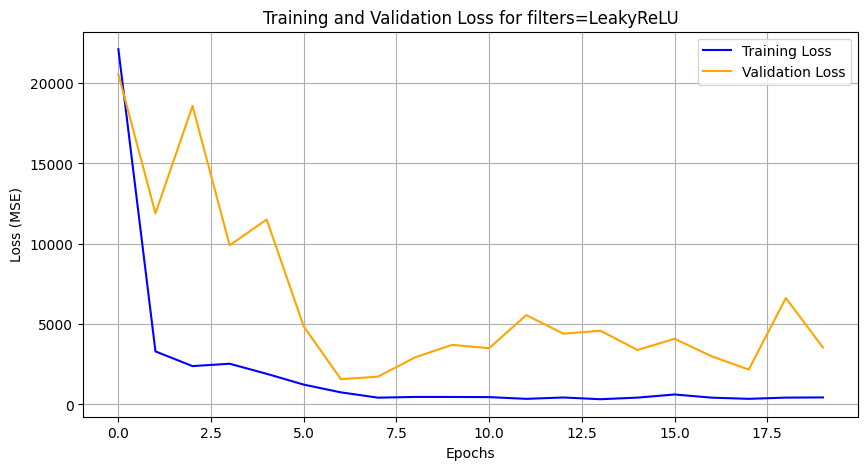

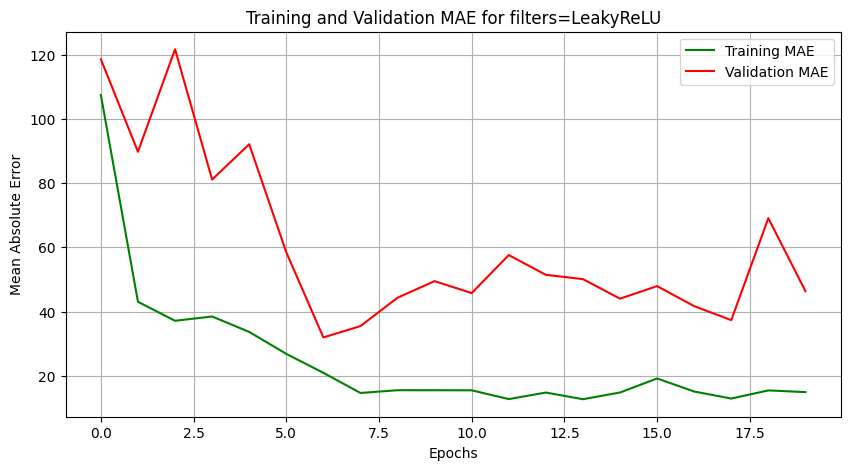

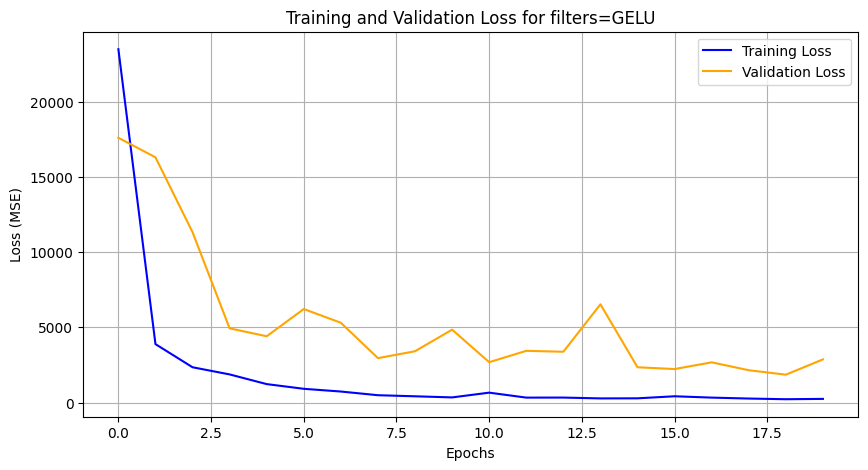

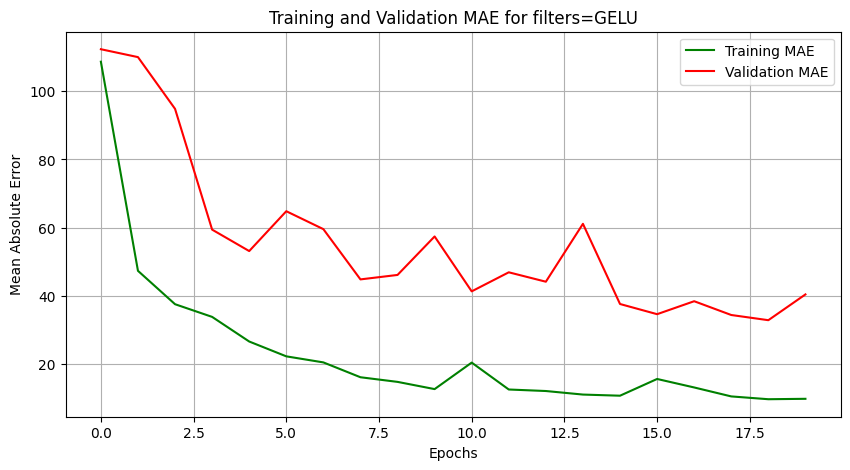

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_leakyrelu, history_gelu]
activation_funcs = ['LeakyReLU', 'GELU']

for history, config in zip(histories, activation_funcs):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_leakyrelu, X_test_cnn, y_test, name="LeakyReLU")
evaluate_model(model_gelu, X_test_cnn, y_test, name="GELU")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📊 LeakyReLU Metrics:
 - R²:   0.6568
 - RMSE: 63.2095
 - MAE:  45.3501
 - MAPE: 33.06%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📊 GELU Metrics:
 - R²:   0.7419
 - RMSE: 54.8101
 - MAE:  37.6360
 - MAPE: 27.76%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128 AND ACTIVATION FUNCTION = GELU**

## **Learning Rate = 0.01**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the updated model with GELU activations
model_gelu1 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_gelu1 = Adam(learning_rate=0.01)

# Compile the model
model_gelu1.compile(optimizer=optimizer_gelu1, loss='mse', metrics=['mae'])

# Train the model
history_gelu1 = model_gelu1.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 113134.1641 - mae: 304.7866 - val_loss: 14433.2881 - val_mae: 101.5410
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7284.0840 - mae: 67.7607 - val_loss: 14802.6855 - val_mae: 102.2443
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6512.5654 - mae: 64.2677 - val_loss: 16494.8203 - val_mae: 106.5033
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5731.3882 - mae: 57.7947 - val_loss: 15836.5723 - val_mae: 104.3911
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4751.7173 - mae: 53.7422 - val_loss: 17153.0957 - val_mae: 109.6618
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2843.1899 - mae: 40.2565 - val_loss: 15419.2061 - val_mae: 105.6731
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2372.2566 - mae: 38.1882 - val_loss: 14392.2510 - val_mae: 102.6685
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2582.2642 - mae: 39.2724 - val_loss: 11993.1895 - val_mae: 91.3450


## **Learning Rate = 0.001**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the updated model with GELU activations
model_gelu2 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_gelu2 = Adam(learning_rate=0.001)

# Compile the model
model_gelu2.compile(optimizer=optimizer_gelu2, loss='mse', metrics=['mae'])

# Train the model
history_gelu2 = model_gelu2.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 168566.5156 - mae: 401.0415 - val_loss: 70176.2578 - val_mae: 231.7103
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 149558.3281 - mae: 377.0045 - val_loss: 42352.7969 - val_mae: 171.4449
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73089.5469 - mae: 253.0296 - val_loss: 8291.9102 - val_mae: 76.9924
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9811.3701 - mae: 83.1125 - val_loss: 8654.9795 - val_mae: 82.3685
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8433.6406 - mae: 72.9348 - val_loss: 8738.7842 - val_mae: 82.7612
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8456.7891 - mae: 74.3530 - val_loss: 9076.1992 - val_mae: 84.0556
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7926.9897 - mae: 71.8905 - val_loss: 9160.8965 - val_mae: 84.4404
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7925.6382 - mae: 71.6535 - val_loss: 9585.9268 - val_mae: 86.0053
Epoch 

## **Learning Rate = 0.0005**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the updated model with GELU activations
model_gelu3 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Same optimizer and learning rate
optimizer_gelu3 = Adam(learning_rate=0.0005)

# Compile the model
model_gelu3.compile(optimizer=optimizer_gelu3, loss='mse', metrics=['mae'])

# Train the model
history_gelu3 = model_gelu3.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 166275.4688 - mae: 398.1599 - val_loss: 73047.5469 - val_mae: 237.0108
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 161166.4688 - mae: 391.5884 - val_loss: 68919.6875 - val_mae: 229.3000
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151075.5312 - mae: 378.8617 - val_loss: 55911.4727 - val_mae: 203.1156
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115422.7656 - mae: 328.0851 - val_loss: 34320.3672 - val_mae: 150.1330
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67505.8047 - mae: 244.0706 - val_loss: 14990.5420 - val_mae: 96.1221
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26962.2852 - mae: 147.4022 - val_loss: 7858.1489 - val_mae: 76.7156
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10426.3994 - mae: 87.0402 - val_loss: 8134.6650 - val_mae: 80.0777
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8488.7900 - mae: 75.0352 - val_loss: 8511.6455 - val_mae: 

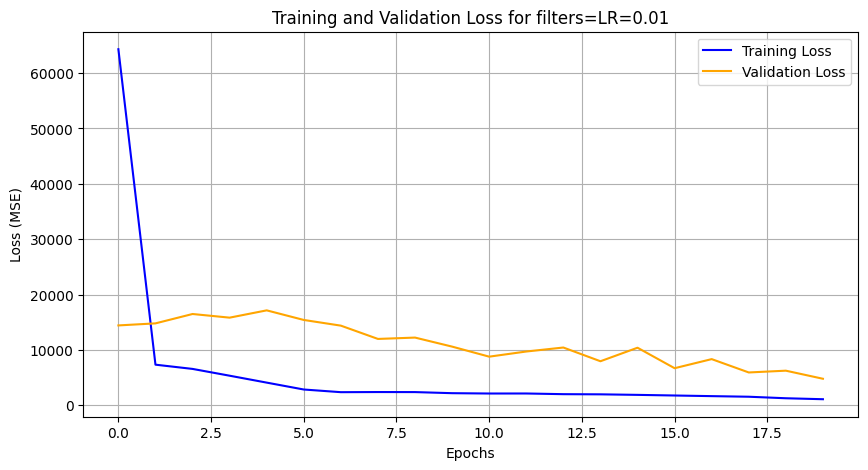

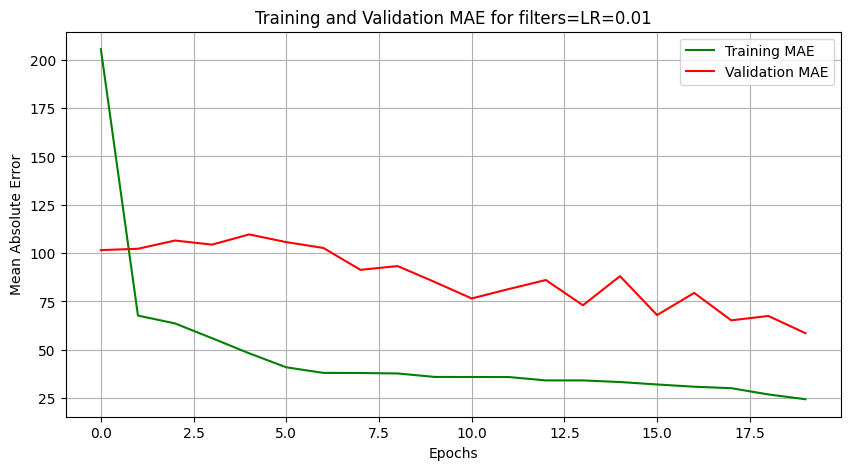

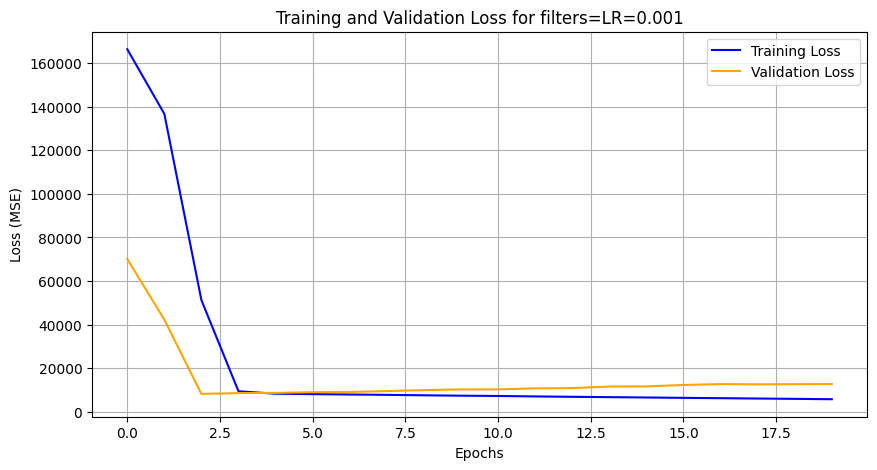

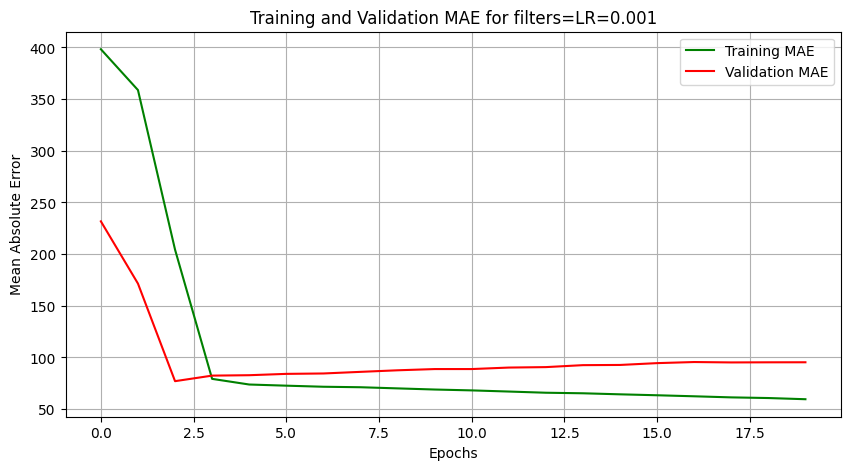

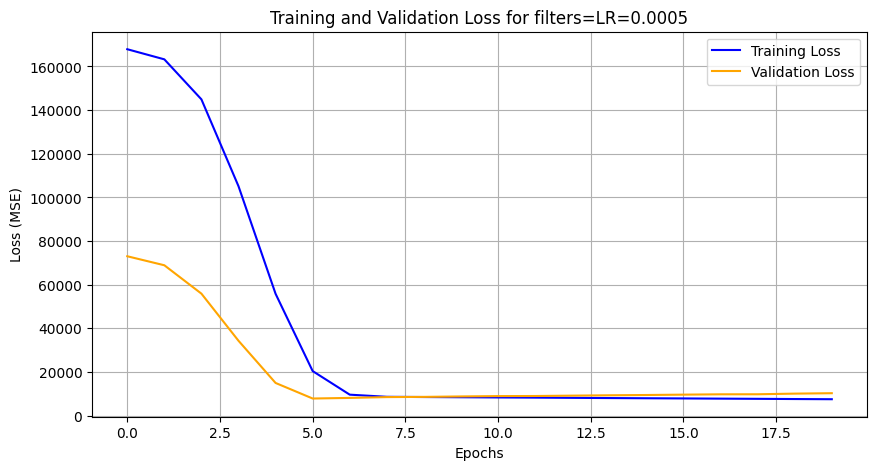

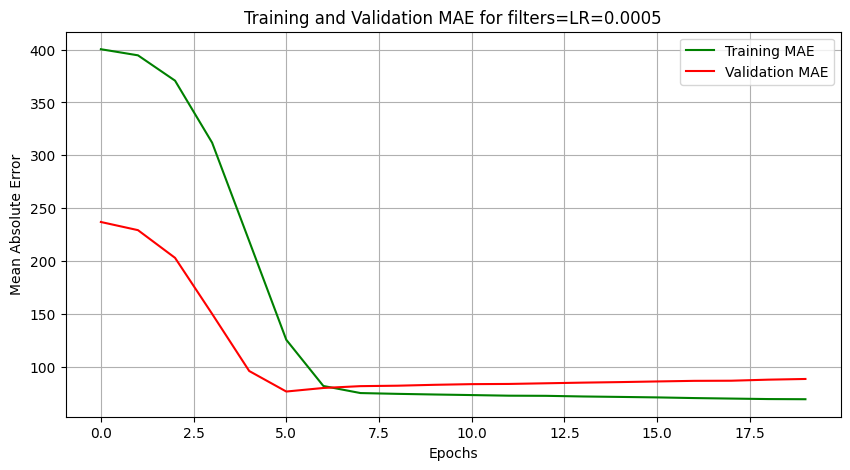

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_gelu1, history_gelu2, history_gelu3]
LRs = ['LR=0.01', 'LR=0.001', 'LR=0.0005']

for history, config in zip(histories, LRs):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_gelu1, X_test_cnn, y_test, name="LR=0.01")
evaluate_model(model_gelu2, X_test_cnn, y_test, name="LR=0.001")
evaluate_model(model_gelu3, X_test_cnn, y_test, name="LR=0.0005")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
📊 LR=0.01 Metrics:
 - R²:   0.5211
 - RMSE: 74.6636
 - MAE:  58.0984
 - MAPE: 41.18%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📊 LR=0.001 Metrics:
 - R²:   0.0147
 - RMSE: 107.0936
 - MAE:  92.7219
 - MAPE: 63.34%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📊 LR=0.0005 Metrics:
 - R²:   0.2194
 - RMSE: 95.3233
 - MAE:  86.5109
 - MAPE: 55.14%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128 AND ACTIVATION FUNCTION = GELU AND LEARNING RATE = 0.1**

## **Optimizer = SGD**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import gelu

# Define the model architecture with GELU activations
model_sgd = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use SGD with the same learning rate as before
optimizer_sgd = SGD(learning_rate=0.0001)

# Compile the model
model_sgd.compile(optimizer=optimizer_sgd, loss='mse', metrics=['mae'])

# Train the model
history_sgd = model_sgd.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 150525.1719 - mae: 371.4213 - val_loss: 26917.8555 - val_mae: 136.5245
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25783.8027 - mae: 125.6564 - val_loss: 21318.5781 - val_mae: 123.1516
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7108.6543 - mae: 66.0778 - val_loss: 45405.7852 - val_mae: 194.8326
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6759.3228 - mae: 63.4848 - val_loss: 10189.7510 - val_mae: 87.7613
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4304.2090 - mae: 52.4006 - val_loss: 14304.0391 - val_mae: 96.5703
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3183.1089 - mae: 43.5782 - val_loss: 19086.7539 - val_mae: 122.5945
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3875.5588 - mae: 49.3906 - val_loss: 12034.1934 - val_mae: 88.2509
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2324.2275 - mae: 37.1204 - val_loss: 8433.6924 - val_mae: 77.7718
Ep

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import gelu

# Define the model architecture with GELU activations
model_rmsprop = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use RMSprop optimizer with the same learning rate
optimizer_rmsprop = RMSprop(learning_rate=0.1)

# Compile the model
model_rmsprop.compile(optimizer=optimizer_rmsprop, loss='mse', metrics=['mae'])

# Train the model
history_rmsprop = model_rmsprop.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 308540.0938 - mae: 316.9258 - val_loss: 22672.7266 - val_mae: 125.8428
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23441.7617 - mae: 118.4882 - val_loss: 78778.3672 - val_mae: 260.4071
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33235.6133 - mae: 144.6629 - val_loss: 27043.1113 - val_mae: 140.2496
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9203.3857 - mae: 76.0211 - val_loss: 9186.0537 - val_mae: 85.2198
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7879.4360 - mae: 61.0742 - val_loss: 15231.1562 - val_mae: 107.2916
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8348.6680 - mae: 65.5487 - val_loss: 13132.7910 - val_mae: 103.6992
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4288.7070 - mae: 50.6315 - val_loss: 35529.8164 - val_mae: 185.2637
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5285.8369 - mae: 51.5452 - val_loss: 3730.1692 - val_mae: 49.1180

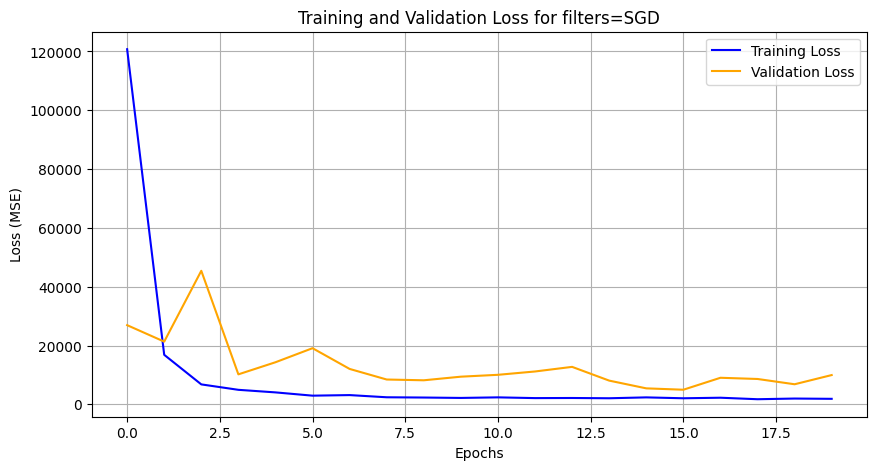

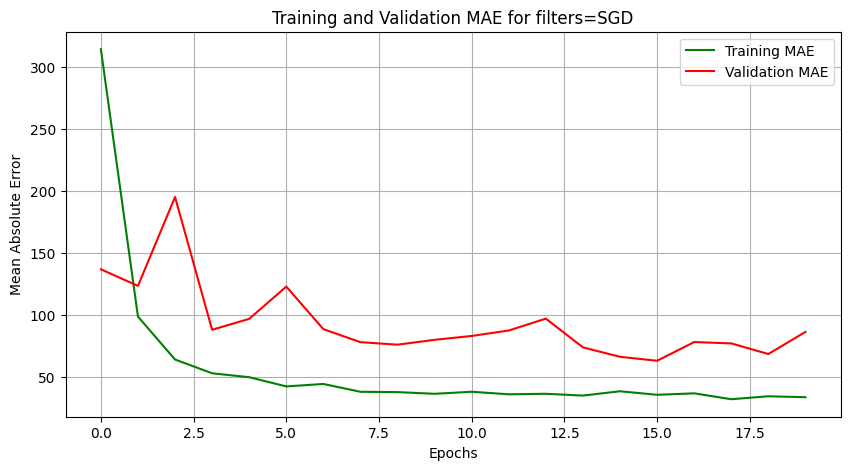

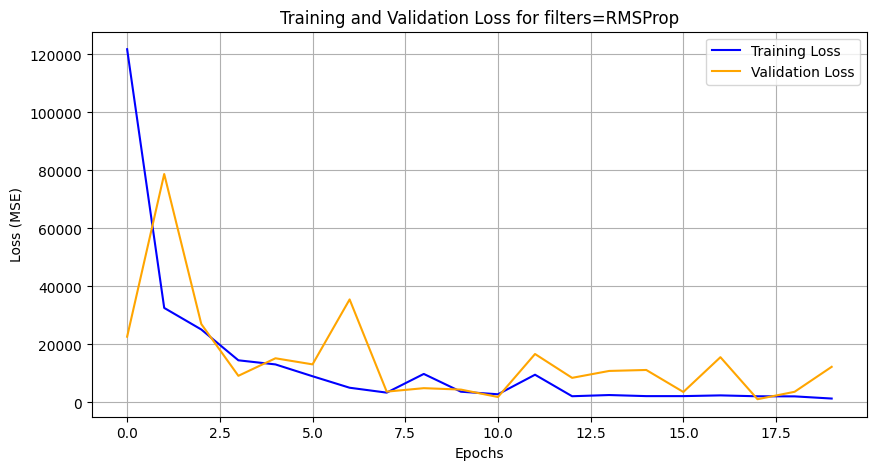

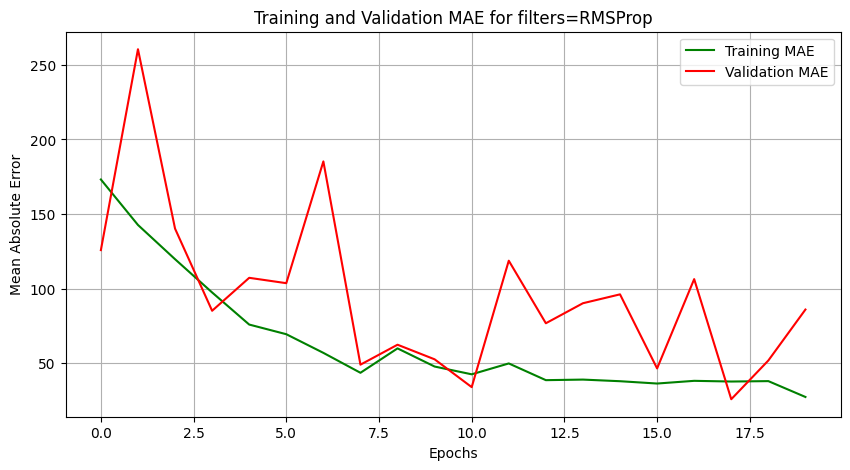

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_sgd, history_rmsprop]
optimizer_funcs = ['SGD', 'RMSProp']

for history, config in zip(histories, optimizer_funcs):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    # Check for NaN values in predictions
    if np.isnan(y_pred).any():
        print(f"⚠️ {name} predictions contain NaN values! Skipping evaluation.\n")
        return

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate both models with safe checks
evaluate_model(model_sgd, X_test_cnn, y_test, name="SGD")
evaluate_model(model_rmsprop, X_test_cnn, y_test, name="RMSProp")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📊 SGD Metrics:
 - R²:   0.0587
 - RMSE: 104.6765
 - MAE:  86.6178
 - MAPE: 59.06%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
📊 RMSProp Metrics:
 - R²:   0.3407
 - RMSE: 87.6046
 - MAE:  66.2237
 - MAPE: 48.35%



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import gelu

# Define the model architecture with GELU activations
model_rmsprop1 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use RMSprop optimizer with the same learning rate
optimizer_rmsprop1 = RMSprop(learning_rate=0.0005)

# Compile the model
model_rmsprop1.compile(optimizer=optimizer_rmsprop1, loss='mse', metrics=['mae'])

# Train the model
history_rmsprop1 = model_rmsprop1.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 168976.6875 - mae: 402.0081 - val_loss: 72445.0078 - val_mae: 235.9029
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164239.3438 - mae: 395.6870 - val_loss: 68614.1406 - val_mae: 228.7294
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 153480.7812 - mae: 382.1306 - val_loss: 61566.9258 - val_mae: 214.9995
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 134090.1250 - mae: 355.6226 - val_loss: 50880.4258 - val_mae: 191.9793
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 110238.2188 - mae: 320.7716 - val_loss: 37839.4258 - val_mae: 159.5854
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80765.6094 - mae: 270.9612 - val_loss: 24361.7266 - val_mae: 123.2585
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49661.2109 - mae: 206.4024 - val_loss: 13394.2715 - val_mae: 90.9730
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23268.5410 - mae: 136.9999 - val_loss: 8013.1084 - v

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    # Check for NaN values in predictions
    if np.isnan(y_pred).any():
        print(f"⚠️ {name} predictions contain NaN values! Skipping evaluation.\n")
        return

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate both models with safe checks

evaluate_model(model_rmsprop1, X_test_cnn, y_test, name="RMSProp")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📊 RMSProp Metrics:
 - R²:   -0.1069
 - RMSE: 113.5144
 - MAE:  97.1857
 - MAPE: 67.07%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128 AND ACTIVATION FUNCTION = GELU AND LEARNING RATE = 0.1 AND OPTIMIZER=ADAM**

## **Loss fucntion=mae**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the updated model with GELU activations
model_gelu_mae_loss = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_gelu = Adam(learning_rate=0.1)

# Compile the model with MAE as the loss function
model_gelu_mae_loss.compile(optimizer=optimizer_gelu, loss='mae', metrics=['mae'])

# Train the model
history_gelu_mae_loss = model_gelu_mae_loss.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 150.7712 - mae: 150.7712 - val_loss: 111.4253 - val_mae: 111.4253
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38.5542 - mae: 38.5542 - val_loss: 74.1517 - val_mae: 74.1517
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.8804 - mae: 32.8804 - val_loss: 109.2949 - val_mae: 109.2949
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.0029 - mae: 33.0029 - val_loss: 52.2058 - val_mae: 52.2058
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.5155 - mae: 25.5155 - val_loss: 46.6505 - val_mae: 46.6505
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.2724 - mae: 19.2724 - val_loss: 38.8695 - val_mae: 38.8695
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.6744 - mae: 35.6744 - val_loss: 66.5007 - val_mae: 66.5007
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0072 - mae: 19.0072 - val_loss: 37.7852 - val_mae: 37.7852
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

## **Loss function = huber**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_gelu_huber = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_gelu = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_gelu_huber.compile(optimizer=optimizer_gelu, loss=Huber(), metrics=['mae'])

# Train the model
history_gelu_huber = model_gelu_huber.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 157.8288 - mae: 158.3271 - val_loss: 138.1478 - val_mae: 138.6475
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.9451 - mae: 56.4432 - val_loss: 75.5972 - val_mae: 76.0972
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.6504 - mae: 43.1474 - val_loss: 100.4818 - val_mae: 100.9818
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.7718 - mae: 28.2660 - val_loss: 55.4552 - val_mae: 55.9524
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.7054 - mae: 30.2015 - val_loss: 63.5234 - val_mae: 64.0229
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.9967 - mae: 24.4899 - val_loss: 52.8110 - val_mae: 53.3042
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0551 - mae: 24.5506 - val_loss: 59.1830 - val_mae: 59.6800
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2699 - mae: 17.7615 - val_loss: 83.2633 - val_mae: 83.7630
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━

## **Loss Function = logcosh**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu

# Define the model with GELU activations
model_gelu_logcosh = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Optimizer and learning rate
optimizer_gelu = Adam(learning_rate=0.1)

# Compile the model with 'log_cosh' loss
model_gelu_logcosh.compile(optimizer=optimizer_gelu, loss='log_cosh', metrics=['mae'])

# Train the model
history_gelu_logcosh = model_gelu_logcosh.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - loss: 192.7945 - mae: 193.4867 - val_loss: 112.4338 - val_mae: 113.1266
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 76.4918 - mae: 77.1818 - val_loss: 112.7353 - val_mae: 113.4266
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.4377 - mae: 38.1251 - val_loss: 64.9901 - val_mae: 65.6793
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.0001 - mae: 38.6854 - val_loss: 71.2699 - val_mae: 71.9610
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 29.2385 - mae: 29.9229 - val_loss: 85.1067 - val_mae: 85.7991
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.9913 - mae: 34.6759 - val_loss: 60.3745 - val_mae: 61.0656
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.3708 - mae: 23.0483 - val_loss: 92.5704 - val_mae: 93.2596
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.3449 - mae: 21.0244 - val_loss: 57.2677 - val_mae: 57.9578
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━

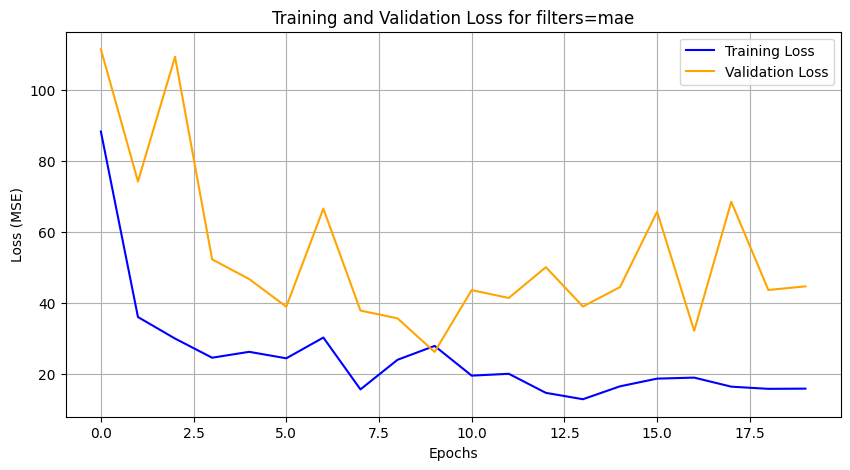

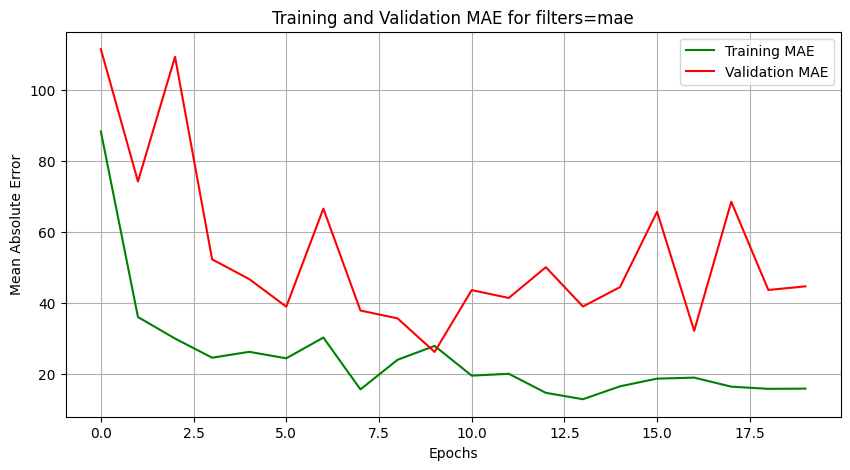

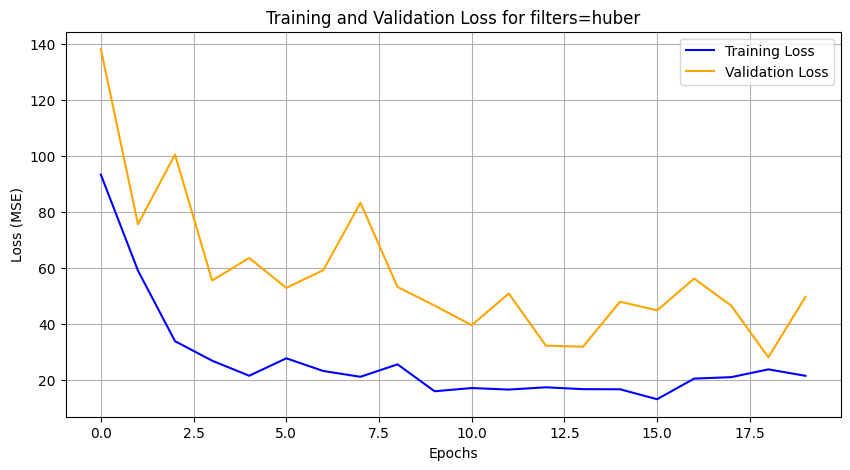

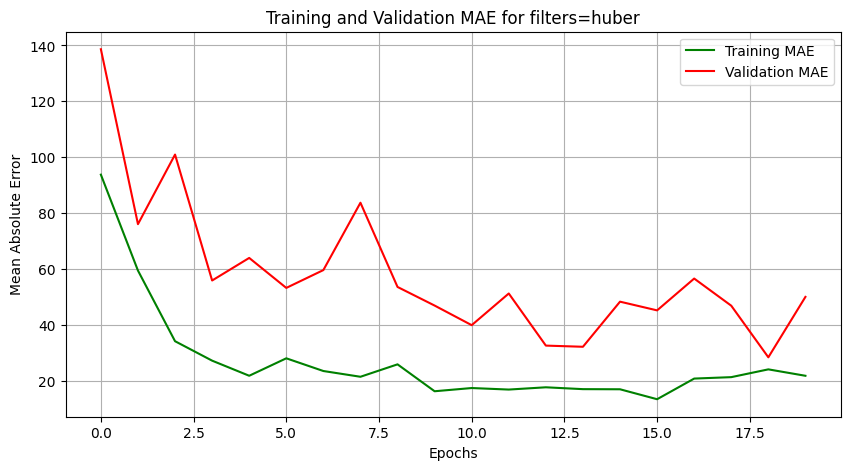

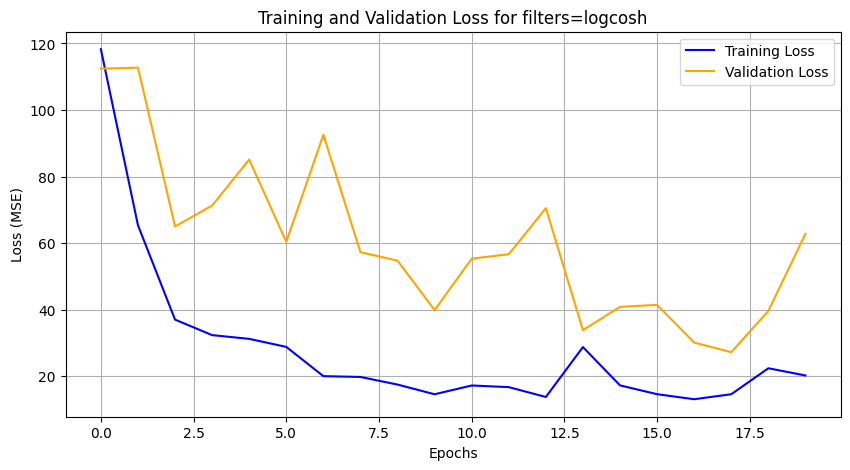

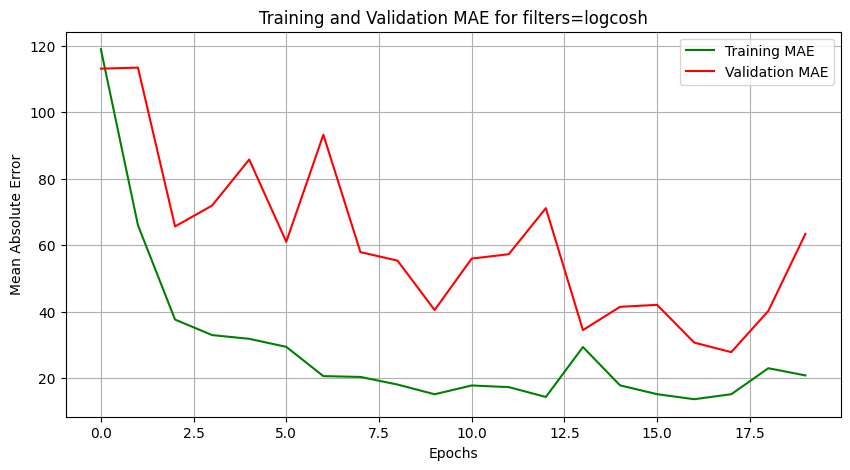

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_gelu_mae_loss, history_gelu_huber, history_gelu_logcosh]
loss_funcs = ['mae', 'huber', 'logcosh']

for history, config in zip(histories, loss_funcs):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_gelu_mae_loss, X_test_cnn, y_test, name="MAE")
evaluate_model(model_gelu_huber, X_test_cnn, y_test, name="HUBER")
evaluate_model(model_gelu_logcosh, X_test_cnn, y_test, name="Logcosh")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📊 MAE Metrics:
 - R²:   0.7343
 - RMSE: 55.6176
 - MAE:  38.1957
 - MAPE: 28.25%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📊 HUBER Metrics:
 - R²:   0.7445
 - RMSE: 54.5337
 - MAE:  38.3290
 - MAPE: 27.11%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📊 Logcosh Metrics:
 - R²:   0.5052
 - RMSE: 75.8952
 - MAE:  57.1720
 - MAPE: 41.39%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128 AND ACTIVATION FUNCTION = GELU AND LEARNING RATE = 0.1 AND OPTIMIZER=ADAM AND LOSS FUNCTION = HUBER**

## **Batch size = 16**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_gelu_huber_16 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_gelu_16 = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_gelu_huber_16.compile(optimizer=optimizer_gelu_16, loss=Huber(), metrics=['mae'])

# Train the model
history_gelu_hube_16 = model_gelu_huber_16.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 125.4699 - mae: 125.9682 - val_loss: 81.7721 - val_mae: 82.2683
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.2803 - mae: 49.7776 - val_loss: 54.5947 - val_mae: 55.0947
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 41.5635 - mae: 42.0608 - val_loss: 108.1716 - val_mae: 108.6696
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.8241 - mae: 24.3203 - val_loss: 54.1353 - val_mae: 54.6308
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.7251 - mae: 22.2212 - val_loss: 86.9188 - val_mae: 87.4178
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.1282 - mae: 28.6261 - val_loss: 64.0185 - val_mae: 64.5159
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.3986 - mae: 19.8915 - val_loss: 36.8943 - val_mae: 37.3918
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.7637 - mae: 16.2553 - val_loss: 60.7824 - val_mae: 61.2824
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_gelu_huber_64 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_gelu_64 = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_gelu_huber_64.compile(optimizer=optimizer_gelu_64, loss=Huber(), metrics=['mae'])

# Train the model
history_gelu_hube_64 = model_gelu_huber_64.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 209.0596 - mae: 209.5591 - val_loss: 140.9687 - val_mae: 141.4685
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 79.9197 - mae: 80.4179 - val_loss: 150.9346 - val_mae: 151.4345
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.2119 - mae: 49.7091 - val_loss: 95.3517 - val_mae: 95.8504
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.1821 - mae: 40.6765 - val_loss: 88.9002 - val_mae: 89.3971
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.3992 - mae: 31.8953 - val_loss: 82.6795 - val_mae: 83.1771
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.6291 - mae: 23.1239 - val_loss: 48.0946 - val_mae: 48.5881
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.8261 - mae: 32.3228 - val_loss: 59.8588 - val_mae: 60.3584
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.3809 - mae: 33.8783 - val_loss: 56.6715 - val_mae: 57.1684
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_gelu_huber_128 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_gelu_128 = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_gelu_huber_128.compile(optimizer=optimizer_gelu_128, loss=Huber(), metrics=['mae'])

# Train the model
history_gelu_hube_128 = model_gelu_huber_128.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 319.3504 - mae: 319.8502 - val_loss: 100.4977 - val_mae: 100.9977
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 96.2825 - mae: 96.7804 - val_loss: 110.7082 - val_mae: 111.2081
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 86.5226 - mae: 87.0219 - val_loss: 160.2968 - val_mae: 160.7954
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.0604 - mae: 65.5586 - val_loss: 144.3395 - val_mae: 144.8390
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 58.3190 - mae: 58.8168 - val_loss: 137.1834 - val_mae: 137.6822
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51.7026 - mae: 52.2000 - val_loss: 131.2746 - val_mae: 131.7722
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 41.7321 - mae: 42.2275 - val_loss: 113.1488 - val_mae: 113.6483
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.4626 - mae: 33.9580 - val_loss: 101.5872 - val_mae: 102.0872
Epoch 9/20
11/11 ━━━━━━━━━━━━

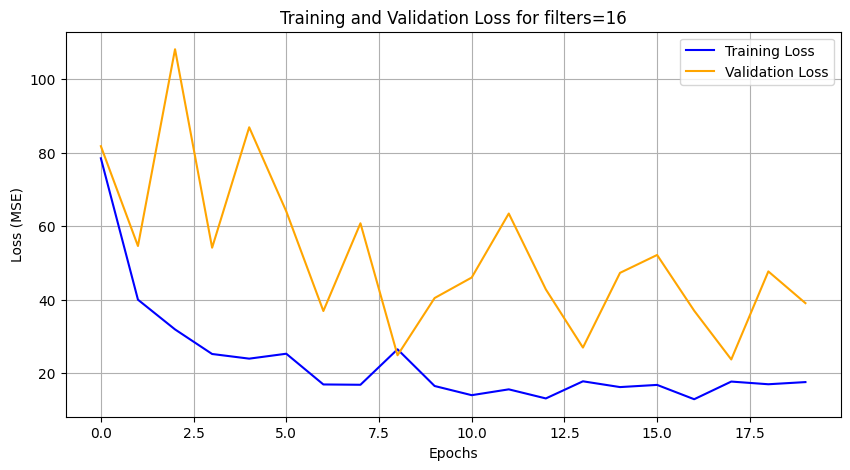

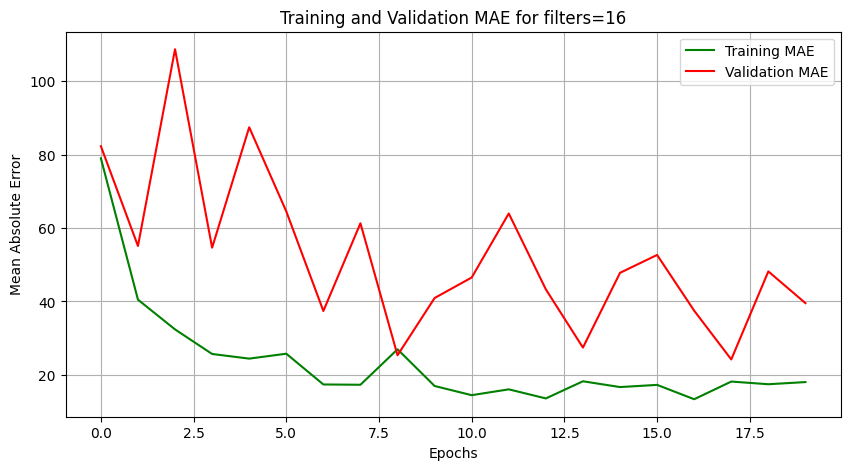

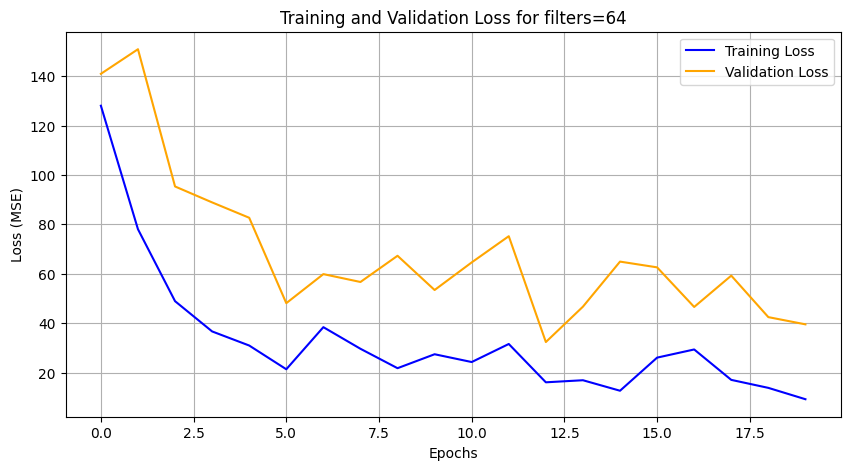

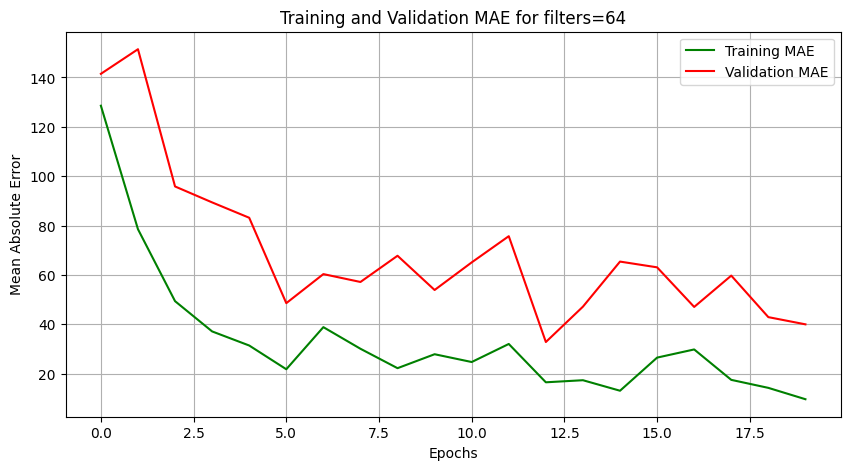

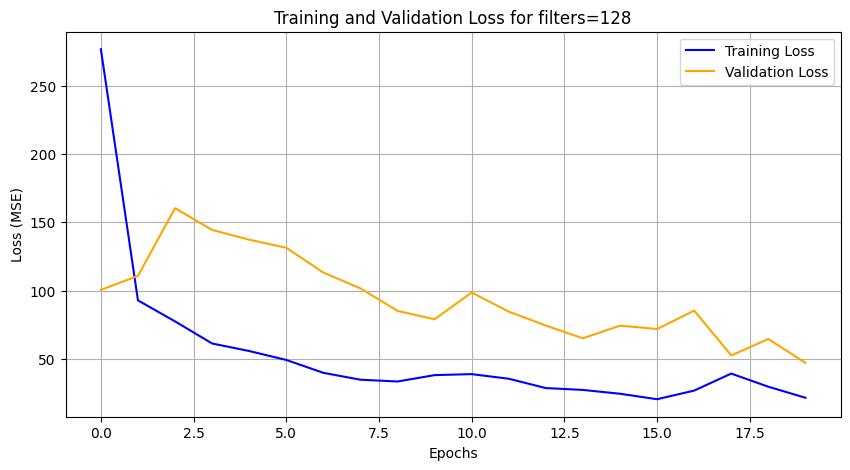

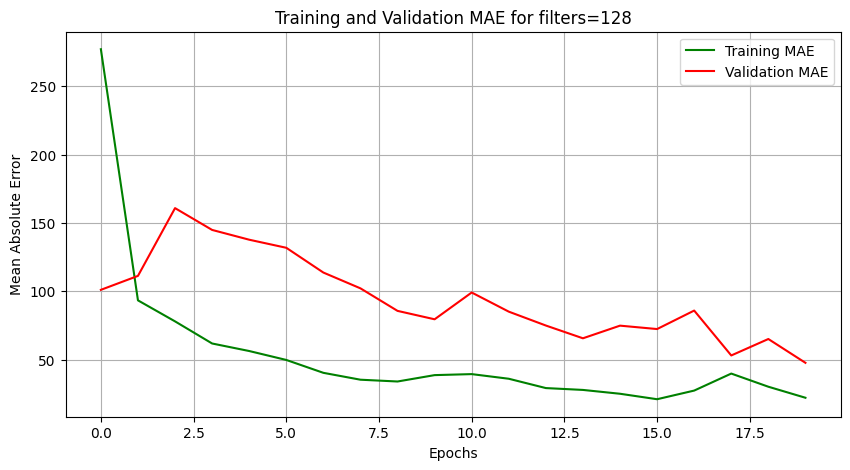

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_gelu_hube_16, history_gelu_hube_64, history_gelu_hube_128]
batch_sizes = ['16', '64', '128']

for history, config in zip(histories, batch_sizes):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_gelu_huber_16, X_test_cnn, y_test, name="16")
evaluate_model(model_gelu_huber_64, X_test_cnn, y_test, name="64")
evaluate_model(model_gelu_huber_128, X_test_cnn, y_test, name="128")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 16 Metrics:
 - R²:   0.7655
 - RMSE: 52.2417
 - MAE:  34.4143
 - MAPE: 25.63%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 64 Metrics:
 - R²:   0.7577
 - RMSE: 53.1120
 - MAE:  36.2903
 - MAPE: 27.24%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 128 Metrics:
 - R²:   0.7361
 - RMSE: 55.4272
 - MAE:  40.6812
 - MAPE: 29.11%



## **CHOSE MODEL WITH NO. OF LAYERS = 2 AND NO. OF FILTERS PER LAYER = 64 -> 128 AND ACTIVATION FUNCTION = GELU AND LEARNING RATE = 0.1 AND OPTIMIZER=ADAM AND LOSS FUNCTION = HUBER AND BATCH SIZE = 16**

## **EPOCHS = 50**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_50 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_50 = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_50.compile(optimizer=optimizer_50, loss=Huber(), metrics=['mae'])

# Train the model
history_50 = model_50.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 118.6010 - mae: 119.0972 - val_loss: 63.2150 - val_mae: 63.7099
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 40.5769 - mae: 41.0744 - val_loss: 73.8976 - val_mae: 74.3947
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.0127 - mae: 29.5091 - val_loss: 72.3818 - val_mae: 72.8781
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.1258 - mae: 23.6220 - val_loss: 56.6205 - val_mae: 57.1196
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.7505 - mae: 25.2454 - val_loss: 45.6756 - val_mae: 46.1700
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.7663 - mae: 24.2609 - val_loss: 49.7079 - val_mae: 50.2044
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.7500 - mae: 24.2438 - val_loss: 32.8221 - val_mae: 33.3176
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 19.5884 - mae: 20.0836 - val_loss: 65.4501 - val_mae: 65.9475
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━

## **EPOCHS = 100**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
model_100 = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
optimizer_100 = Adam(learning_rate=0.1)

# Compile the model with Huber loss
model_100.compile(optimizer=optimizer_100, loss=Huber(), metrics=['mae'])

# Train the model
history_100 = model_100.fit(
    X_train_cnn, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 138.3396 - mae: 138.8389 - val_loss: 84.2683 - val_mae: 84.7659
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 36.7651 - mae: 37.2613 - val_loss: 91.0279 - val_mae: 91.5279
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 41.3198 - mae: 41.8159 - val_loss: 61.8556 - val_mae: 62.3556
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 41.1842 - mae: 41.6826 - val_loss: 43.6435 - val_mae: 44.1401
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.0296 - mae: 21.5222 - val_loss: 89.4026 - val_mae: 89.9026
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0955 - mae: 20.5908 - val_loss: 40.1645 - val_mae: 40.6634
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.7702 - mae: 17.2620 - val_loss: 75.1938 - val_mae: 75.6932
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5163 - mae: 17.0075 - val_loss: 45.8285 - val_mae: 46.3275
Epoch 9/100
87/87 ━━━━━━━━━━━

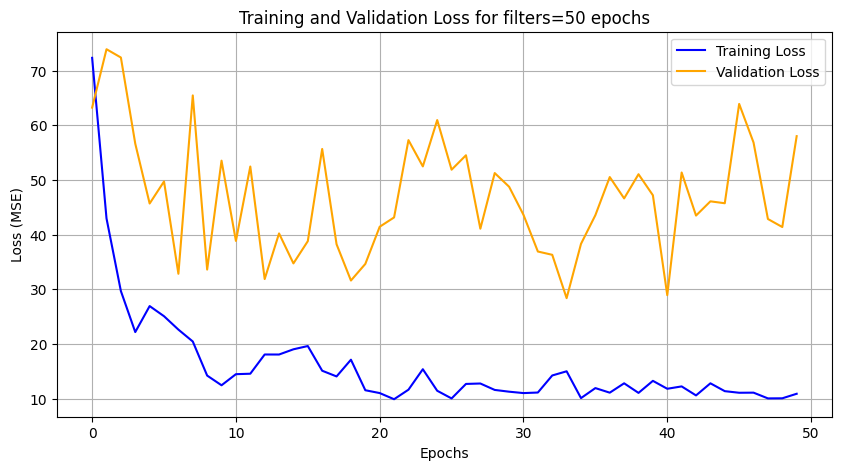

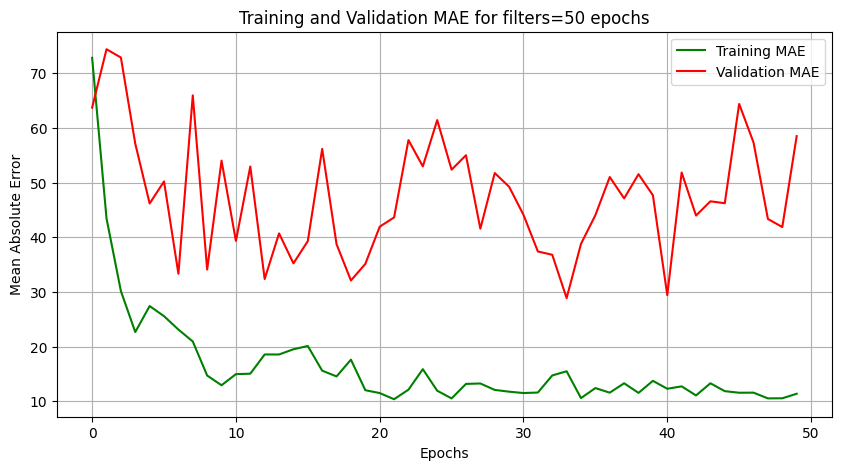

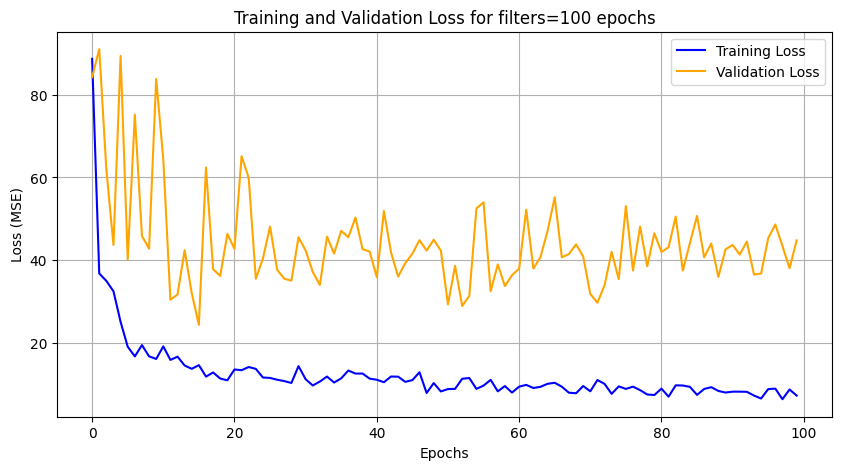

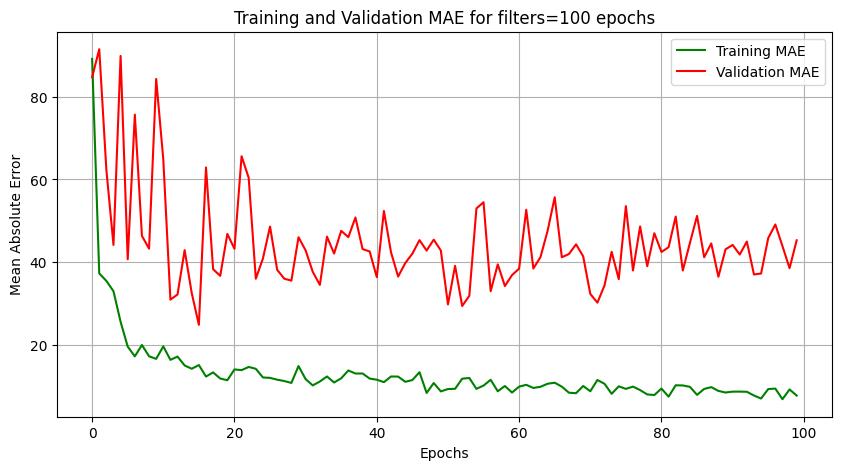

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual history objects
histories = [history_50, history_100]
epochs_num = ['50 epochs', '100 epochs']

for history, config in zip(histories, epochs_num):
    # Plot: Loss (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (Train + Val)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE', color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title(f'Training and Validation MAE for filters={config}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

evaluate_model(model_50, X_test_cnn, y_test, name="50")
evaluate_model(model_100, X_test_cnn, y_test, name="100")



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
📊 50 Metrics:
 - R²:   0.5527
 - RMSE: 72.1595
 - MAE:  55.6410
 - MAPE: 40.19%

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
📊 100 Metrics:
 - R²:   0.6777
 - RMSE: 61.2512
 - MAE:  42.3975
 - MAPE: 31.93%



# Chose CNN model with-

1) No. of layers = 2
2) No. of filters per layer = 64 -> 128
3) Activation function = GELU
4) Learning Rate = 0.1
5) Optimizer = Adam
6) Loss function = Huber
7) Batch size = 16
8) Epochs = 20

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# Define the updated model with GELU activations
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    Activation(gelu),

    Conv1D(filters=128, kernel_size=2),
    Activation(gelu),

    Flatten(),
    Dense(1)  # Output layer for regression
])

# Use same optimizer and learning rate
cnn_optimizer = Adam(learning_rate=0.1)

# Compile the model with Huber loss
cnn_model.compile(optimizer=cnn_optimizer, loss=Huber(), metrics=['mae'])

# Train the model
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_cnn, y_val),
    verbose=1
)
